In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

import random
import math
import time
import random
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA

#TODO try TSNE instead of PCA
#Try multihead inanother notebook

In [2]:
HID_DIM = 64
ENC_LAYERS = 1
DEC_LAYERS = 1
ENC_HEADS = 1
DEC_HEADS = 1
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

def get_head_count():
    return ENC_HEADS

def get_row_count():
    return 1

def get_col_count():
    return 1

In [3]:
#!pip install yellowbrick

In [4]:
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data,show_info=True,summary_count=summary_count)
        
    def get_summary(self,labels,show_data=False,show_info=False,summary_count=1):
        if show_info:
            print("summary_count",summary_count,"   self.capacity ",self.capacity)
        count = 0
        values = []
        for i in range(summary_count):
            #print(i," ------------------------------------------------")
            for l in labels:
                if i < len(self.tensor_datas.get(l)):
                    label_data = self.tensor_datas.get(l)[i]
                    values.append(label_data)
                    if show_info:
                        print(l)
                    if torch.is_tensor(label_data):
                        if show_info:
                            print( list(label_data.size() ) )
                    if not show_data and not torch.is_tensor(label_data):
                        if show_info:
                            print(label_data)
                    if show_data:    
                        print(label_data)
        return values              
                    
loggers = {}                    
current_logger = StepLogger(100)   
def add_new_logger(logger_label):
    global current_logger
    if logger_label in loggers.keys() :
        print("using existing logger")
        current_logger = loggers[logger_label]
    else:    
        loggers[logger_label]  = StepLogger(50)
        current_logger = loggers[logger_label]
    

def add_infos(datas,labels,labels_prefix=""):
    #print( id(current_logger))
    for i in range(len(datas)):
        final_label = labels_prefix+"@"+labels[i]
        current_logger.add_info(datas[i],final_label.strip())
    
#add_info   tensor_data,tensor_label                  currentLogger.get_default_summary(show_data=False)

data_pipeline = []
pipeline_enabled = True
#do no want to log during eval mode
def disable_pipeline():
    global pipeline_enabled
    pipeline_enabled = False

def enable_pipeline():
    global pipeline_enabled
    pipeline_enabled = True
    
def add_pipeline_info(label,data):
    if pipeline_enabled:
        data_pipeline.append( (label,data) )
    

In [5]:
#!pip install torchtext
#!pip install spacy

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
#spacy_en = spacy.load('en')
#spacy_en = spacy.load("en_core_web_sm")

In [8]:
#tok = spacy.load("en_core_web_sm")
#tokde = spacy.load("de_core_news_sm")
#import de_core_news_sm
#spacy_de = de_core_news_sm.load()

In [9]:
#spacy_de.tokenizer("i mochte lesen")

In [10]:
#!python -m spacy download de


In [11]:
#spacy_de = spacy.load('de')

In [12]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok for tok in text.split(" ")]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok for tok in text.split(" ")]

In [13]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [14]:
tabular_set = torchtext.data.TabularDataset(
path='D:/nnidata/eng_de3.csv', format='csv',
fields=[('src', SRC),
        ('trg', TRG)])

In [15]:
#dump a sample
print(tabular_set[0].src)
print(tabular_set[0].trg)
print(tabular_set[10].trg)


['i', 'want', 'to', 'eat', 'bread']
['ich', 'mochten', 'brot', 'essen']
['ich', 'konnen', 'buch', 'lesen']


In [16]:
#TODO can generate different items for each
#Real line in tutorial
#train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))
train_data, valid_data, test_data = tabular_set ,tabular_set, tabular_set

In [17]:
#all of our vocublary is used at least 2 times
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [19]:
#our tranining size is so small so batch size will also be small
BATCH_SIZE = 8


In [20]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x:  len(x.src),
     device = device)


In [21]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask,attention_type):
    
        add_infos([src],["src_source"],"Encoder")
        add_pipeline_info(label="Encoder->attention",data=src)
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        #print("Encoder src",src)
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        add_infos([src,pos],["src","pos"],"Encoder")   
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask,attention_type)
            
        
        add_infos([src],["src_final"],"Encoder")    
        #src = [batch size, src len, hid dim]
            
        return src

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"encoder")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask,attention_type):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
           
        #self attention
        _src, sattention = self.self_attention(src, src, src,attention_type, src_mask) #return x, attention
        
        #dropout, residual connection and layer norm
        src2 = self.self_attn_layer_norm(src + self.dropout(_src))
        
        ###At the end attention is learning a new representation for a sentence,here _src is a helper representation
        add_pipeline_info(label="EncoderSSS"+"@SSS",data=[src,_src,src2])  
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src2 = self.positionwise_feedforward(src2)
        
        #dropout, residual and layer norm
        src3 = self.ff_layer_norm(src + self.dropout(_src2))
        
        add_infos([_src,src2,_src2,src3,src_mask,sattention],["_src","src2","_src2","src3","src_mask","sattention"],"EncoderLayer")
        #src = [batch size, src len, hid dim]
        
        return src3

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    #since this layer is common while logging there must be a label to differantiate labels
    def __init__(self, hid_dim, n_heads, dropout, device,layer_label):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        #TODO head_dim is encoding per head so ,hid_dim must divide n_heads
        self.head_dim = hid_dim // n_heads
        self.layer_label = layer_label
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        add_infos([self.hid_dim,self.n_heads,self.head_dim],["hid_dim","n_heads","head_dim"],self.layer_label)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value,attention_type, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        add_infos([Q,K,V],["Q","K","V"],self.layer_label)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        
        
        attention = torch.softmax(energy, dim = -1)
        
        
        
        ### attention is a weight over dimensions
        if attention_type == 2: #normally distributed literally means no attention            
            attention = torch.tensor(np.full(attention.shape, 1/attention.shape[3]),dtype=torch.float32 )
        #just pay attention to beginning
        #at last dimension shape is flat 1, 2, 1, 1    
        if attention_type == 3:           
            if attention.shape[3] > 2: 
                real_shape = attention.shape
                att1 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], 3), 1/3) ,dtype=torch.float32 )
                att2 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], real_shape[3] - 3), 1/7) ,dtype=torch.float32 )
                att3 = torch.cat( (att1,att2),3 )
                attention = torch.softmax(att3, dim = -1)
                
        if attention_type == 4:           
            if attention.shape[3] > 2: 
                real_shape = attention.shape                
                att1 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], real_shape[3] - 1), 0) ,dtype=torch.float32 )
                att2 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], 1), 1) ,dtype=torch.float32 )
                att3 = torch.cat( (att1,att2),3 )
                attention = torch.softmax(att3, dim = -1)         
            
            
            #print("new attention",attention)
                
        #attention = [batch size, n heads, query len, key len]
                
        x1 = torch.matmul(self.dropout(attention), V)
        
        add_pipeline_info(label=self.layer_label+"@QKV",data=[Q,K,V,mask,energy,attention,mask,x1])
        
        #x = [batch size, n heads, query len, head dim]
        
        x2 = x1.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x3 = x2.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x4 = self.fc_o(x3)
        
        #x = [batch size, query len, hid dim]
        
        add_infos([energy,mask,attention],["energy","mask","attention"],self.layer_label)
        add_infos([x1,x2,x3,x4],["x1","x2","x3","x4"],self.layer_label)
        
        return x4, attention

In [24]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x1 = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x2 = self.fc_2(x1)
        
        #x = [batch size, seq len, hid dim]
        add_infos([x1,x2],["x1","x2"],"PositionwiseFeedforwardLayer")
        
        return x2

In [25]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,attention_type=1):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        add_pipeline_info(label="Decoder_original->trg",data=trg)         
           
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask,attention_type)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        add_infos([pos,trg,output,attention],["pos","trg","output","attention"],"Decoder")
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_self")
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_encoder_attention")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,attention_type):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        add_pipeline_info(label="Decoder_self->attention",data=trg) 
        _trg1, _ = self.self_attention(trg, trg, trg,attention_type, trg_mask)
        
        #dropout, residual connection and layer norm
        trg2 = self.self_attn_layer_norm(trg + self.dropout(_trg1))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        add_pipeline_info(label="Decoder->encoder_attention",data=trg2) 
        _trg2, attention = self.encoder_attention(trg2, enc_src, enc_src,attention_type, src_mask)
        
        #dropout, residual connection and layer norm
        trg3 = self.enc_attn_layer_norm(trg2 + self.dropout(_trg2))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg3 = self.positionwise_feedforward(trg3)
        
        #dropout, residual and layer norm
        trg4 = self.ff_layer_norm(trg3 + self.dropout(_trg3))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        add_infos([_trg1,trg2,_trg2,trg3,_trg3,trg4,attention,trg_mask, src_mask],["_trg1","trg2","_trg2","trg3","_trg3","trg4","attention","trg_mask", "src_mask"],"DecoderLayer")
        
        return trg4, attention

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg,attention_type):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        #print("Seq2Seq src",src)
        enc_src = self.encoder(src, src_mask,attention_type)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask,attention_type)
        
        add_infos([src_mask,trg_mask,enc_src,output,attention],["src_mask","trg_mask","enc_src","output","attention"],"Seq2Seq")
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)


enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [30]:
print("SRC_PAD_IDX",SRC_PAD_IDX)
print("TRG_PAD_IDX",TRG_PAD_IDX)
print(SRC.vocab.itos[10])
print(SRC.vocab.stoi[SRC.vocab.itos[10]])

SRC_PAD_IDX 1
TRG_PAD_IDX 1
to
10


In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 99,857 trainable parameters


In [32]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [33]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(18, 64)
    (pos_embedding): Embedding(100, 64)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=64, out_features=64, bias=True)
          (fc_k): Linear(in_features=64, out_features=64, bias=True)
          (fc_v): Linear(in_features=64, out_features=64, bias=True)
          (fc_o): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=64, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dr

In [34]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [36]:
def train(model, iterator, optimizer, criterion, clip,attention_type):
    
    model.train()
    
    epoch_loss = 0
    
    print("train1")
    
    for i, batch in enumerate(iterator):
        #print("train2",i,batch)
        
        
        src = batch.src
        trg = batch.trg
        
        #print("train src",src)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1],attention_type)
        
        
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        
        
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def evaluate(model, iterator, criterion,attention_type):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1],attention_type)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
import os
import gc
N_EPOCHS = 30
CLIP = 1
best_valid_loss = float('inf')

add_new_logger("training")


model_save_path = "D:/nnidata/tut6-model_en_de.pt"
model_to_train = model
for epoch in range(N_EPOCHS):
    gc.collect()
    if os.path.isfile(model_save_path) :
        print("loading model",model_save_path)
        #TODO
        #model_to_train.load_state_dict(torch.load(model_save_path))
    
    start_time = time.time()
    
    enable_pipeline()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP,attention_type=1)
    
    disable_pipeline()
    valid_loss = evaluate(model, valid_iterator, criterion,attention_type=1)    
    
    end_time = time.time()
    
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        print("saving model",model_save_path," with loss ",valid_loss)
        best_valid_loss = valid_loss
        torch.save(model_to_train.state_dict(), model_save_path)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')    

loading model D:/nnidata/tut6-model_en_de.pt
train1
saving model D:/nnidata/tut6-model_en_de.pt  with loss  2.7126770496368406
Epoch: 01 | Time: 0m 0s
	Train Loss: 3.247 | Train PPL:  25.706
	 Val. Loss: 2.713 |  Val. PPL:  15.070
loading model D:/nnidata/tut6-model_en_de.pt
train1
saving model D:/nnidata/tut6-model_en_de.pt  with loss  2.2611355066299437
Epoch: 02 | Time: 0m 0s
	Train Loss: 2.657 | Train PPL:  14.253
	 Val. Loss: 2.261 |  Val. PPL:   9.594
loading model D:/nnidata/tut6-model_en_de.pt
train1
saving model D:/nnidata/tut6-model_en_de.pt  with loss  1.9791063785552978
Epoch: 03 | Time: 0m 0s
	Train Loss: 2.348 | Train PPL:  10.464
	 Val. Loss: 1.979 |  Val. PPL:   7.236
loading model D:/nnidata/tut6-model_en_de.pt
train1
saving model D:/nnidata/tut6-model_en_de.pt  with loss  1.7458755254745484
Epoch: 04 | Time: 0m 0s
	Train Loss: 2.174 | Train PPL:   8.791
	 Val. Loss: 1.746 |  Val. PPL:   5.731
loading model D:/nnidata/tut6-model_en_de.pt
train1
saving model D:/nnidata/

In [40]:
import pandas as pd
import seaborn as sns

def test_sentence(src,draw_charts,attention_type=1,dump_result=True):
    
    if isinstance(src,str):
        src = src.split(" ")
    logger_name = "".join(src)+str( random.randint(1,180001) )
    add_new_logger(logger_name)
    if dump_result:
        print(f'src = {src}')

    translation, attention,all_outputs = translate_sentence(src, SRC, TRG, model, device,attention_type=attention_type)

    if dump_result:
        print(f'predicted trg = {translation}')
    output_words = translation
    output_words[len(output_words)-1] = "EOS"
    output_words = [ str(index+1)+")"+ word for index,word in enumerate(output_words)]
    df2 = pd.DataFrame(all_outputs,columns=["unk","pad","sos","eos"]+TRG.vocab.itos[4:],index=output_words)
    cm = sns.light_palette("blue", as_cmap=True)

    styled_df = df2.style.background_gradient(cmap=cm)
    if draw_charts:
        display(styled_df)    
        display_attention(src, translation, attention,n_heads=get_head_count(),n_rows = get_row_count(), n_cols = get_col_count())
    return loggers[logger_name],all_outputs,translation




def show_on_vis_multi(new_input_embeddings,input_sentences,valid_sentences_embeddings,valid_sentences):
    #print("new_input_embedding",new_input_embedding)
    Xs = valid_sentences_embeddings
    Ys = valid_sentences
   
    if len(input_sentences)> 0 :
        input_sentences = [ "<<<"+s+">>>" for s in input_sentences]
        Xs = Xs+ [embed for embed in new_input_embeddings]
        Ys = Ys + input_sentences 
        
    #tsne = TSNEVisualizer(labels=Ys,title="How output of encoder looks",random_state=42)
    #result = tsne.fit_transform(np.array(Xs),Ys)
    #tsne = TSNEVisualizer()
    #result =tsne.fit_transform(np.array(Xs),Ys)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(np.array(Xs))

    #result = fitted.transformer_.fit_transform(np.array(Xs))
    #print("input_sentences",input_sentences)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    #scatter result words
    plt.scatter(result[:, 0], result[:, 1])
    words = list(Ys)
    #put an annotation on x,y cordinates for words
    #print("input_sentences",input_sentences)
    for i, word in enumerate(words):
        #print("wordi",word,i,type(word))
        if word in input_sentences:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00ff')
        elif "eat" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff0000')     
        else:
            #print("else",word)
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00dd')
    plt.show()    
    

def get_color(word):
    cmap = plt.get_cmap('viridis')
    distinct_words = SRC.vocab.itos[4:]
    #print("distinct_words",len(distinct_words))
    colors = cmap(np.linspace(0, 1, len(distinct_words)))
    color_map = { w:colors[i] for i,w in enumerate(distinct_words) }
    #print("color_map",color_map)
    for distinct_word in distinct_words:
        if  word.find(distinct_word) == 0: #if starstwith
            #print("word color",word," --> ", color_map[distinct_word])
            return color_map[distinct_word]
    #print("colors",colors)
    return color_map[distinct_words[0]]
    
def map_on_3d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    ax = plt.axes(projection ="3d")
    #scatter result words
    ax.scatter3D(data_2d[:, 0], data_2d[:, 1], data_2d[:, 2])
    
    
    
    #put an annotation on x,y cordinates for words
    #print("input_sentences",input_sentences)
    for i, word in enumerate(words):
        #print("wordi",word,i,type(word))
        if color_mapping is not None:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=color_mapping[i] )
        elif word in exceptional_words:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff' )
        elif use_word_colors:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=get_color(word))
        elif "eat" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff')
        elif "drink" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#00ff00')
        elif "read" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff0000')     
        else:
            #print("else",word)
            #plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff00dd')
    plt.show()
    
def map_on_2d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(data_2d[:, 0], data_2d[:, 1])
    
    
    
    #put an annotation on x,y cordinates for words
    #print("input_sentences",input_sentences)
    for i, word in enumerate(words):
        #print("wordi",word,i,type(word))
        if color_mapping is not None:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=color_mapping[i] )
        elif word in exceptional_words:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff' )
        elif use_word_colors:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=get_color(word))
        elif "eat" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff0000')     
        else:
            #print("else",word)
            #plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
    plt.show()      
    
def encoding_to_sentence(encodings,language):
    return [encoding_to_word(i,language) for i in encodings ]   
def encoding_to_word(embedding_index,language):
    return language.vocab.itos[embedding_index]     

def draw_df(data,columns,indexes):
    df2 = pd.DataFrame(data,columns=columns,index=indexes)
    cm = sns.light_palette("blue", as_cmap=True)
    styled_df = df2.style.background_gradient(cmap=cm)
    display(styled_df)
    
def translate_sentence(sentence, src_field, trg_field, model, device,attention_type, max_len = 10):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask,attention_type)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    ### hold output of linear layer at everytime step
    all_outputs = []
    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask,attention_type)
        
        # #print("trg_mask",trg_mask)
        #print("src_mask",src_mask)
        #print("output.argmax(2)->",output.argmax(2))
        #print("output->",output.shape)
        #print("attention->",attention.shape)
        all_outputs.append(output[:, -1:, :].numpy().flatten())
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention,all_outputs

def display_attention(sentence, translation, attention, n_heads = get_head_count(), n_rows = get_row_count(), n_cols = get_col_count()):
    
    assert n_rows * n_cols == n_heads
    figsize = (5,5) if n_cols == 1 else (20,15)
    print("figsize",figsize," n_cols ",n_cols,"  n_heads",n_heads)
    fig = plt.figure(figsize=figsize) 
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()    

In [41]:
SRC.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x00000200BADCC788>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'i': 4,
             'we': 5,
             'can': 6,
             'drink': 7,
             'eat': 8,
             'read': 9,
             'to': 10,
             'want': 11,
             'apple': 12,
             'beer': 13,
             'book': 14,
             'bread': 15,
             'newspaper': 16,
             'water': 17})

In [42]:
class DebugStepWord:
    def __init__(self,sentence,translation):
        self.q = None
        self.k = None
        self.v = None
        self.energy = None
        self.attention = None
        self.mask = None
        self.x1 = None
        self.sentence = sentence
        self.translation = translation
        self.original_embedding = None 
        self.word_vector = None #only filled if done at world level
        self.word_translation = None #only filled if done at world level
        self.word_embeddding  = None #only filled if done at world level
        
    def summary(self):
        print("q",self.q.shape)
        print("k",self.k.shape)
        print("v",self.v.shape)
        print("attention",self.attention.shape)
        print("energy",self.energy.shape)
        print("mask",self.mask.shape)
        print("x1",self.x1.shape)
        print("x1",self.x1.shape)
        print("word_translation",self.word_translation)
        print("translation",self.translation)


In [43]:
all_sentences = {}
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    for i in range( (src.shape[0]) ):
        print( encoding_to_sentence(src[i],SRC) ,encoding_to_sentence(trg[i],TRG)  )
        all_sentences[" ".join(encoding_to_sentence(src[i],SRC)) ] = " ".join(encoding_to_sentence(trg[i],TRG) )

def find_src_sentence_from_trg(trg_sentence):
    for src in all_sentences.keys():
        if all_sentences[src].find( trg_sentence) >= 0:
            return src
    assert 1 == 2
    
#last word is trimmed so here find full version of sentence    
def find_fullsentence_from_trg(trg_sentence):
    for src in all_sentences.keys():
        if all_sentences[src].find( trg_sentence) >= 0:
            return all_sentences[src]
    assert 1 == 2    
#assert find_src_sentence("ich essen apfel")    == "<sos> i eat bread <eos> <pad> <pad>"
print(find_src_sentence_from_trg("ich essen apfel"))
print(find_fullsentence_from_trg("ich essen apfel"))
assert find_fullsentence_from_trg("ich essen apfel") == "<sos> ich essen apfel <eos> <pad>"
#assert "<sos> i eat bread <eos> <pad> <pad>" ==  find_src_sentence_from_trg("ich essen apfel")

['<sos>', 'i', 'want', 'to', 'drink', 'water', '<eos>'] ['<sos>', 'ich', 'mochten', 'wasser', 'trinken', '<eos>']
['<sos>', 'we', 'drink', 'beer', '<eos>', '<pad>', '<pad>'] ['<sos>', 'wir', 'trinken', 'bier', '<eos>', '<pad>']
['<sos>', 'we', 'read', 'book', '<eos>', '<pad>', '<pad>'] ['<sos>', 'wir', 'lesen', 'buch', '<eos>', '<pad>']
['<sos>', 'we', 'drink', 'water', '<eos>', '<pad>', '<pad>'] ['<sos>', 'wir', 'trinken', 'wasser', '<eos>', '<pad>']
['<sos>', 'we', 'can', 'eat', 'apple', '<eos>', '<pad>'] ['<sos>', 'wir', 'konnen', 'apfel', 'essen', '<eos>']
['<sos>', 'we', 'can', 'drink', 'water', '<eos>', '<pad>'] ['<sos>', 'wir', 'konnen', 'wasser', 'trinken', '<eos>']
['<sos>', 'i', 'read', 'book', '<eos>', '<pad>', '<pad>'] ['<sos>', 'ich', 'lesen', 'buch', '<eos>', '<pad>']
['<sos>', 'i', 'eat', 'apple', '<eos>', '<pad>', '<pad>'] ['<sos>', 'ich', 'essen', 'apfel', '<eos>', '<pad>']
['<sos>', 'we', 'eat', 'apple', '<eos>', '<pad>', '<pad>'] ['<sos>', 'wir', 'essen', 'apfel', '<

In [44]:
steps_decoder_bysentence = []
LANG = TRG
last_sentence_encoding_batch = None
last_sentence_original_batch = None
for i in range(len(data_pipeline)):
    #print( data_pipeline[i][0] )
    current_label = data_pipeline[i][0]
    if "decoder_encoder_attention@QKV" == current_label: # TODO encoder@QKV
         #cnt += 1
         #print("i",i)
         sentence_batch = last_sentence_encoding_batch
         batch_len = sentence_batch.shape[0]   
         #assert batch_len == len(data_pipeline[i][1] )
         #for zip_index,data_tuple in enumerate(zip(last_sentence_batch,data_pipeline[i][1])):
         for sent_index in range(batch_len):  
            sentence = sentence_batch[sent_index]
            data_part = data_pipeline[i][1]
            original_embedding = last_sentence_original_batch[sent_index]
            translation = " ".join( encoding_to_sentence(original_embedding,TRG) )
            dstep = DebugStepWord(sentence,translation)
            dstep.original_embedding = original_embedding 
            dstep.q = data_pipeline[i][1][0][sent_index].squeeze().detach()
            dstep.k = data_pipeline[i][1][1][sent_index].squeeze().detach()
            dstep.v = data_pipeline[i][1][2][sent_index].squeeze().detach()
            dstep.energy = data_pipeline[i][1][4][sent_index].squeeze().detach()
            dstep.attention = data_pipeline[i][1][5][sent_index].squeeze().detach()
            dstep.mask = data_pipeline[i][1][6][sent_index].squeeze().detach()
            dstep.x1 = data_pipeline[i][1][7][sent_index].squeeze().detach()
            steps_decoder_bysentence.append(dstep)
    if "Decoder->encoder_attention" == current_label: #TODO Encoder->attention
         #print("i",i)
         last_sentence_encoding_batch = data_pipeline[i][1]
    if "Decoder_original->trg" == current_label: #TODO Encoder->attention
         #print("i",i)
         last_sentence_original_batch = data_pipeline[i][1]    
         
         #Ss.append(data_pipeline[i][1])

In [45]:
#assert list(steps_decoder_bysentence[0].q.shape) == [5,64]

In [46]:
assert N_EPOCHS * len(steps_decoder_bysentence) * 36
print( " epochs: ",N_EPOCHS , " log length : ", len(steps_decoder_bysentence) )
# num epoch x 36 sentence  

 epochs:  30  log length :  1080


In [47]:
assert steps_decoder_bysentence[0].v.shape[0] == 7
assert steps_decoder_bysentence[0].v.shape[1] == HID_DIM 


In [48]:
steps_decoder_byword = []
for step in steps_decoder_bysentence:
    word_count = step.q.shape[0]
    for i in range(word_count):        
        word_step = DebugStepWord(step.sentence,step.translation)    
        #print("step.q",step.q.shape)
        word_step.q = step.q[i]
        word_step.k = step.k[i]
        word_step.v = step.v[i]
        word_step.energy = step.energy[i]
        word_step.attention = step.attention[i]
        word_step.mask = step.mask[i]
        word_step.x1 = step.x1[i]
        word_step.sentence = step.sentence
        word_step.translation = step.translation
        word_step.word_vector = step.sentence[i]
        word_step.word_embeddding = step.original_embedding[i]
        #print("step.sentence.squeeze()[i]",word_step.word_embeddding )
        word_step.word_translation = encoding_to_word(word_step.word_embeddding,LANG)
        steps_decoder_byword.append( word_step )

#assert steps_decoder_byword[0].q.shape[0] == 64 #indexes must be single dimension
#assert steps_decoder_byword[0].word_vector.shape[0] == 64 #indexes must be single dimension

In [49]:
print(steps_decoder_byword[0].word_translation)
print(steps_decoder_byword[0].q.shape)
print(steps_decoder_byword[1].word_translation)
print(steps_decoder_byword[1].q.shape)
steps_decoder_byword[0].summary()

<sos>
torch.Size([64])
wir
torch.Size([64])
q torch.Size([64])
k torch.Size([64])
v torch.Size([64])
attention torch.Size([7])
energy torch.Size([7])
mask torch.Size([])
x1 torch.Size([64])
x1 torch.Size([64])
word_translation <sos>
translation <sos> wir konnen apfel essen


In [50]:
def get_by_sentence(search_sentence,steps):
    return [ step for step in steps if step.translation.find(search_sentence) >=0 ]
    
#TODO delete    
def get_by_wordTODO(search_sentence,keywords,steps_word):
    steps_for_sample = get_by_sentence(search_sentence,steps_word)
    return [ step for step in steps_for_sample if step.word_translation in keywords ]

def get_by_word(search_sentence,keywords,steps_word):
    steps_for_sample = get_by_sentence(search_sentence,steps_word)
    keyword_map = {}
    for step in steps_for_sample :
        if step.word_translation in keywords :
            if step.word_translation in keyword_map.keys():
                keyword_map[step.word_translation] = keyword_map[step.word_translation]+[step]
            else:    
                keyword_map[step.word_translation] = [step]
            
    return keyword_map
       

In [51]:
search_sentence = "wir konnen apfel essen"
steps_for_sample = get_by_word(search_sentence,["wir"],steps_decoder_byword)
#getting word per sentence so must be 1 word per 1 sentence 1 epoch
assert len(steps_for_sample["wir"]) == N_EPOCHS 
steps_for_sample = get_by_word(search_sentence,["wir","konnen"],steps_decoder_byword)
print(len(steps_for_sample) )
print(steps_for_sample.keys()) 
assert len(steps_for_sample["wir"]) == N_EPOCHS 
assert len(steps_for_sample["konnen"]) == N_EPOCHS 



2
dict_keys(['wir', 'konnen'])


In [52]:
def steps_for_target(search_sentence):
    steps_for_sample = get_by_sentence(search_sentence,steps_decoder_bysentence)
    for index,step in enumerate(steps_for_sample):
        if index == 0 or (index+1) % 10 == 0:
            print("training step :",index)
            attention = step.attention.detach().numpy()
            splits = step.translation.split(" ")
            splits = [s.replace("<","").replace(">","") for s in splits]
            splits = [ str(index)+")"+s for index,s in enumerate(splits)]
            #print("splits",splits)
            src_sentence_splits = find_src_sentence_from_trg(step.translation).split(" ")
            src_sentence_splits = [s.replace("<","").replace(">","").replace("pad","pad"+str(index)) for index,s in enumerate(src_sentence_splits)]
            #print("src_sentence_splits",src_sentence_splits)
            draw_df(np.array(attention),columns=src_sentence_splits,indexes=splits)

In [53]:
steps_for_target("wir essen apfel")

training step : 0


,sos,we,eat,apple,eos,pad5,pad6
0)sos,0.602825,0.077456,0.114571,0.031671,0.173478,0.000000,0.000000
1)wir,0.451365,0.072982,0.213580,0.132878,0.129195,0.000000,0.000000
2)essen,0.524583,0.112546,0.254654,0.061612,0.046606,0.000000,0.000000
3)apfel,0.531691,0.141379,0.241601,0.065184,0.020145,0.000000,0.000000
4)eos,0.496835,0.099734,0.137633,0.155687,0.110111,0.000000,0.000000


training step : 9


,sos,we,eat,apple,eos,pad5,pad6
0)sos,0.029150,0.477464,0.408988,0.041379,0.043018,0.000000,0.000000
1)wir,0.054810,0.109393,0.154032,0.583311,0.098454,0.000000,0.000000
2)essen,0.893947,0.004774,0.015317,0.014123,0.071839,0.000000,0.000000
3)apfel,0.741800,0.105608,0.062817,0.047153,0.042621,0.000000,0.000000
4)eos,0.764760,0.043628,0.070953,0.055147,0.065512,0.000000,0.000000


training step : 19


,sos,we,eat,apple,eos,pad5,pad6
0)sos,0.012840,0.929606,0.025007,0.005625,0.026922,0.000000,0.000000
1)wir,0.385200,0.094516,0.435167,0.046945,0.038172,0.000000,0.000000
2)essen,0.418333,0.010421,0.147076,0.024149,0.400020,0.000000,0.000000
3)apfel,0.468887,0.083422,0.147614,0.018969,0.281108,0.000000,0.000000
4)eos,0.234743,0.040071,0.103235,0.212142,0.409808,0.000000,0.000000


training step : 29


,sos,we,eat,apple,eos,pad5,pad6
0)sos,0.013547,0.777803,0.141020,0.017172,0.050458,0.000000,0.000000
1)wir,0.140702,0.075917,0.637182,0.119362,0.026837,0.000000,0.000000
2)essen,0.467310,0.022278,0.050405,0.052259,0.407748,0.000000,0.000000
3)apfel,0.347799,0.157167,0.186024,0.053902,0.255109,0.000000,0.000000
4)eos,0.153822,0.099936,0.352346,0.283274,0.110622,0.000000,0.000000


In [54]:
steps_for_target("wir mochten apfel essen")

training step : 0


,sos,we,want,to,eat,apple,eos
0)sos,0.105963,0.024630,0.261551,0.511260,0.037594,0.012532,0.046469
1)wir,0.046987,0.042463,0.259516,0.346003,0.135984,0.112988,0.056058
2)mochten,0.277291,0.108639,0.130627,0.290773,0.035716,0.040402,0.116553
3)apfel,0.287196,0.074890,0.055110,0.213007,0.288466,0.045464,0.035868
4)essen,0.294937,0.073617,0.019181,0.146404,0.221410,0.086747,0.157703


training step : 9


,sos,we,want,to,eat,apple,eos
0)sos,0.006292,0.082482,0.444295,0.384630,0.057774,0.013993,0.010534
1)wir,0.046639,0.034858,0.206335,0.071239,0.215669,0.288698,0.136561
2)mochten,0.043797,0.092813,0.024633,0.773951,0.030810,0.014145,0.019851
3)apfel,0.708653,0.027571,0.027173,0.028964,0.153970,0.026611,0.027058
4)essen,0.823879,0.003347,0.003881,0.003657,0.047788,0.024925,0.092523


training step : 19


,sos,we,want,to,eat,apple,eos
0)sos,0.007947,0.412924,0.150270,0.352700,0.041115,0.011115,0.023928
1)wir,0.001247,0.002894,0.977484,0.000731,0.008460,0.007136,0.002047
2)mochten,0.315846,0.066252,0.003360,0.324638,0.047578,0.030169,0.212157
3)apfel,0.060825,0.061216,0.033762,0.021625,0.787570,0.025764,0.009239
4)essen,0.417168,0.046028,0.045014,0.143289,0.169074,0.058058,0.121369


training step : 29


,sos,we,want,to,eat,apple,eos
0)sos,0.008764,0.775582,0.067145,0.063451,0.057384,0.005015,0.022659
1)wir,0.002325,0.004183,0.978592,0.001147,0.011397,0.001778,0.000577
2)mochten,0.024829,0.028623,0.009426,0.673356,0.014319,0.091186,0.158261
3)apfel,0.360368,0.026871,0.069881,0.020885,0.394289,0.092969,0.034737
4)essen,0.292980,0.007818,0.014133,0.084357,0.042622,0.028905,0.529185


In [55]:
steps_for_target("wir konnen apfel essen")

training step : 0


,sos,we,can,eat,apple,eos,pad6
0)sos,0.735373,0.030728,0.017175,0.135153,0.057993,0.023578,0.000000
1)wir,0.056888,0.145926,0.084429,0.391376,0.270425,0.050956,0.000000
2)konnen,0.713899,0.017331,0.037501,0.117430,0.066322,0.047517,0.000000
3)apfel,0.382448,0.055288,0.203555,0.172393,0.053406,0.132909,0.000000
4)essen,0.377554,0.033728,0.023514,0.338133,0.160508,0.066564,0.000000


training step : 9


,sos,we,can,eat,apple,eos,pad6
0)sos,0.020472,0.652543,0.074950,0.107559,0.073267,0.071209,0.000000
1)wir,0.035246,0.043261,0.442414,0.075773,0.100124,0.303182,0.000000
2)konnen,0.174911,0.105902,0.457735,0.107053,0.073764,0.080635,0.000000
3)apfel,0.762410,0.026323,0.141052,0.044427,0.009264,0.016524,0.000000
4)essen,0.824187,0.002972,0.058268,0.053911,0.016561,0.044101,0.000000


training step : 19


,sos,we,can,eat,apple,eos,pad6
0)sos,0.001602,0.973363,0.003934,0.009360,0.003805,0.007936,0.000000
1)wir,0.007595,0.024367,0.933287,0.025618,0.006540,0.002593,0.000000
2)konnen,0.354633,0.272794,0.050991,0.065276,0.132464,0.123842,0.000000
3)apfel,0.129404,0.071971,0.013582,0.754149,0.018599,0.012296,0.000000
4)essen,0.541655,0.005088,0.027396,0.090929,0.036740,0.298193,0.000000


training step : 29


,sos,we,can,eat,apple,eos,pad6
0)sos,0.003853,0.883123,0.042983,0.048145,0.006342,0.015554,0.000000
1)wir,0.019449,0.029532,0.686865,0.201029,0.020117,0.043008,0.000000
2)konnen,0.218165,0.100325,0.110696,0.048274,0.411410,0.111131,0.000000
3)apfel,0.206266,0.012501,0.013870,0.657045,0.049381,0.060936,0.000000
4)essen,0.526320,0.005115,0.042018,0.067357,0.127594,0.231596,0.000000


In [56]:
search_sentence = "wir konnen apfel essen" if LANG == TRG else "<sos> we can eat apple <eos>"
"""
steps_for_sample = get_by_sentence(search_sentence,steps_decoder_bysentence)
#I must have samples len equal to epochs, at each epoch i process it once
assert len(steps_for_sample) == N_EPOCHS

for index,step in enumerate(steps_for_sample):
    if index % 10 == 0:
        print("training step :",index)
        attention = step.attention.detach().numpy()
        #print("attention",attention.shape)
        splits = step.translation.split(" ")
        splits = [s.replace("<","").replace(">","") for s in splits]
        #print("find_src_sentence_from_trg(step.translation)",find_src_sentence_from_trg(step.translation))
        src_sentence_splits = find_src_sentence_from_trg(step.translation).split(" ")
        src_sentence_splits = [s.replace("<","").replace(">","") for s in src_sentence_splits]
        #print("src_sentence_splits",src_sentence_splits)
        draw_df(np.array(attention),columns=src_sentence_splits,indexes=splits)
"""        
    

'\nsteps_for_sample = get_by_sentence(search_sentence,steps_decoder_bysentence)\n#I must have samples len equal to epochs, at each epoch i process it once\nassert len(steps_for_sample) == N_EPOCHS\n\nfor index,step in enumerate(steps_for_sample):\n    if index % 10 == 0:\n        print("training step :",index)\n        attention = step.attention.detach().numpy()\n        #print("attention",attention.shape)\n        splits = step.translation.split(" ")\n        splits = [s.replace("<","").replace(">","") for s in splits]\n        #print("find_src_sentence_from_trg(step.translation)",find_src_sentence_from_trg(step.translation))\n        src_sentence_splits = find_src_sentence_from_trg(step.translation).split(" ")\n        src_sentence_splits = [s.replace("<","").replace(">","") for s in src_sentence_splits]\n        #print("src_sentence_splits",src_sentence_splits)\n        draw_df(np.array(attention),columns=src_sentence_splits,indexes=splits)\n'

In [57]:
#includes : list of vectors to add Q,K,V,A
def map_word_by_sentence(steps_for_sample,includes="QV",ranks=[0,15,N_EPOCHS-1]):
    Xs = []
    Ys = []
    for key in steps_for_sample.keys():
        for index,step in enumerate(steps_for_sample[key]):
            #print("index:",index)            
            if "Q" in includes:
                Xs.append( step.q.numpy())
                Ys.append( key+"@Q@"+str(index) )
            if "K" in includes:
                Xs.append( step.k.numpy())
                Ys.append( key+"@K@"+str(index) )
            if "V" in includes:
                Xs.append( step.v.numpy())
                Ys.append( key+"@V@"+str(index) )
            if "X" in includes:
                Xs.append( step.x1.numpy())
                Ys.append( key+"@X1@"+str(index) )     
    return filter_by_indexes(Xs,Ys,ranks)

def filter_by_indexes(Xs,Ys,ranks):
    Xnew = []
    Ynew = []
    for val,key in zip(Xs,Ys):        
        item_rank = key.split("@")[2]
        if int(item_rank) in ranks:
            Xnew.append(val)
            Ynew.append(key)
    return Xnew,Ynew    

def filter_by_key(Xs,Ys,keys):
    X_new,Y_new = [],[]
    for val,key in zip(Xs,Ys):
        if key.split("@")[0] in keys:
            X_new.append(val)
            Y_new.append(key)
    return X_new,Y_new        

def get_as_map(Xs,Ys,map_keys):
    xy_map = {}
    for val,key in zip(Xs,Ys):
        if key in map_keys:
            xy_map[key]=val
    return xy_map       


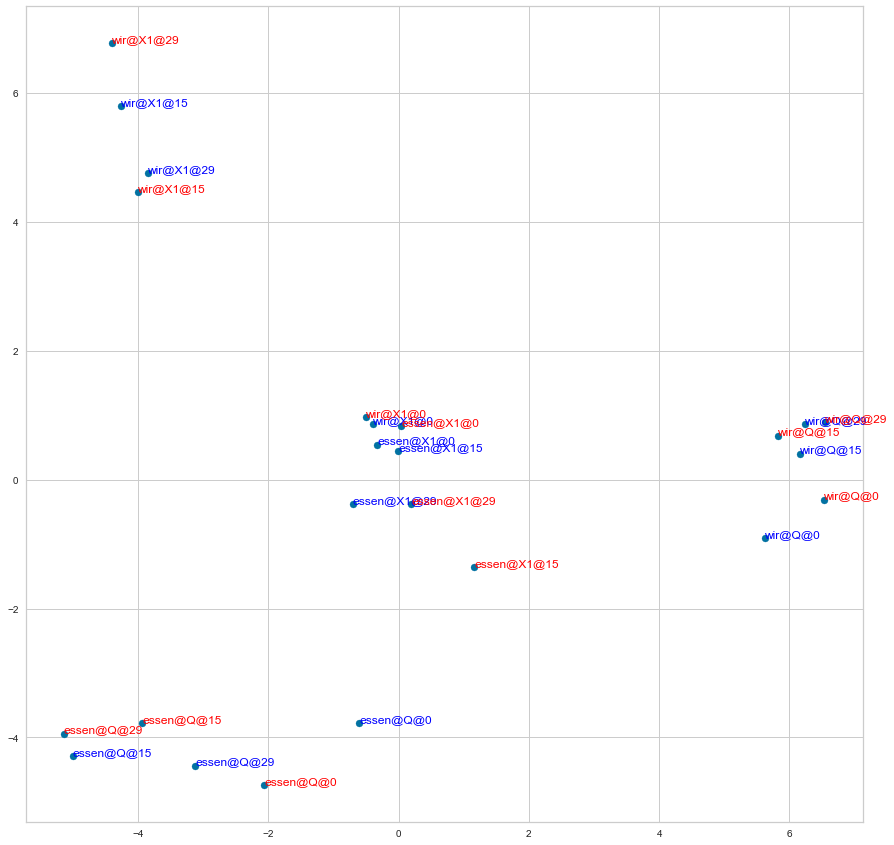

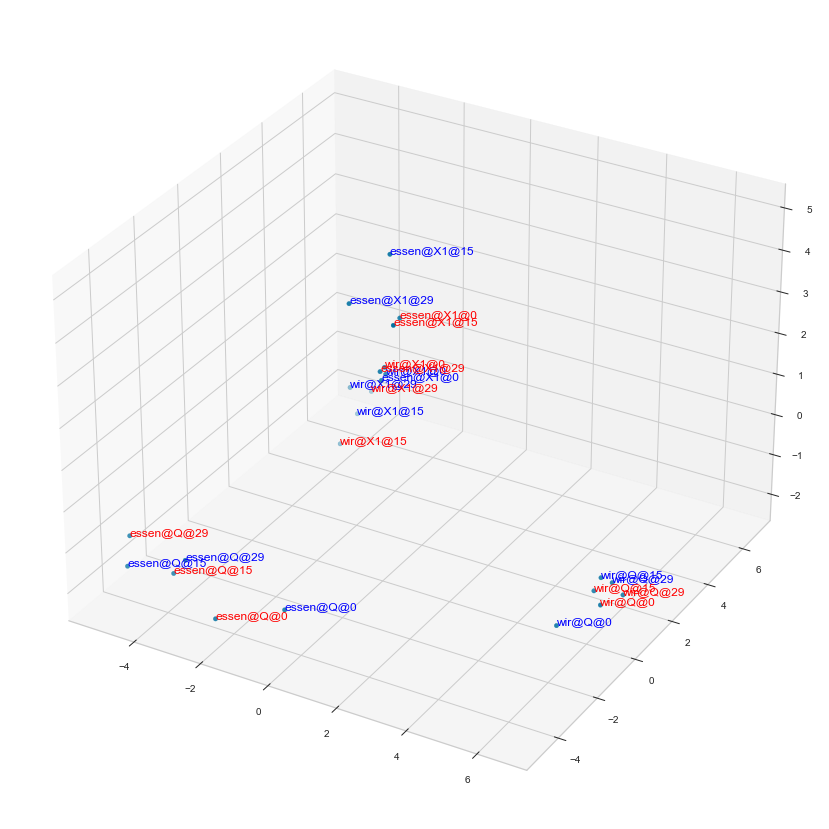

In [58]:
#altough wir and esses are same words, their embedding changed over time
#mapping on 2d changes over time, and network learns to differentiate better on final encoding
#final encoding is on 29th step.
search_sentence = "wir konnen apfel essen"
steps_for_sample = get_by_word(search_sentence,["essen","wir"],steps_decoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QX")

search_sentence2 = "wir konnen brot essen"
steps_for_sample2 = get_by_word(search_sentence2,["essen","wir"],steps_decoder_byword)
X_s2,Y_s2 = map_word_by_sentence(steps_for_sample2,includes="QX")

Xs = X_s1 + X_s2
Ys = [ s for s in Y_s1] + [ s for s in Y_s2]
color_mapping = [ "#0000ff" for s in Y_s1] + [ "#ff0000" for s in Y_s2]


pca = PCA(n_components=2)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

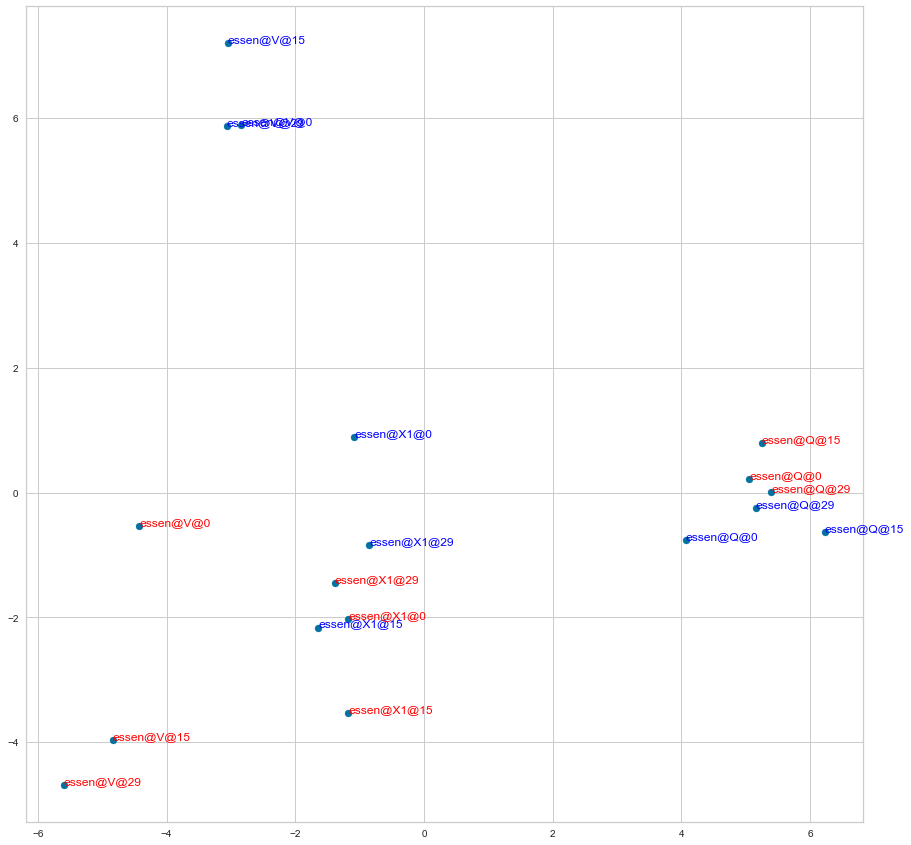

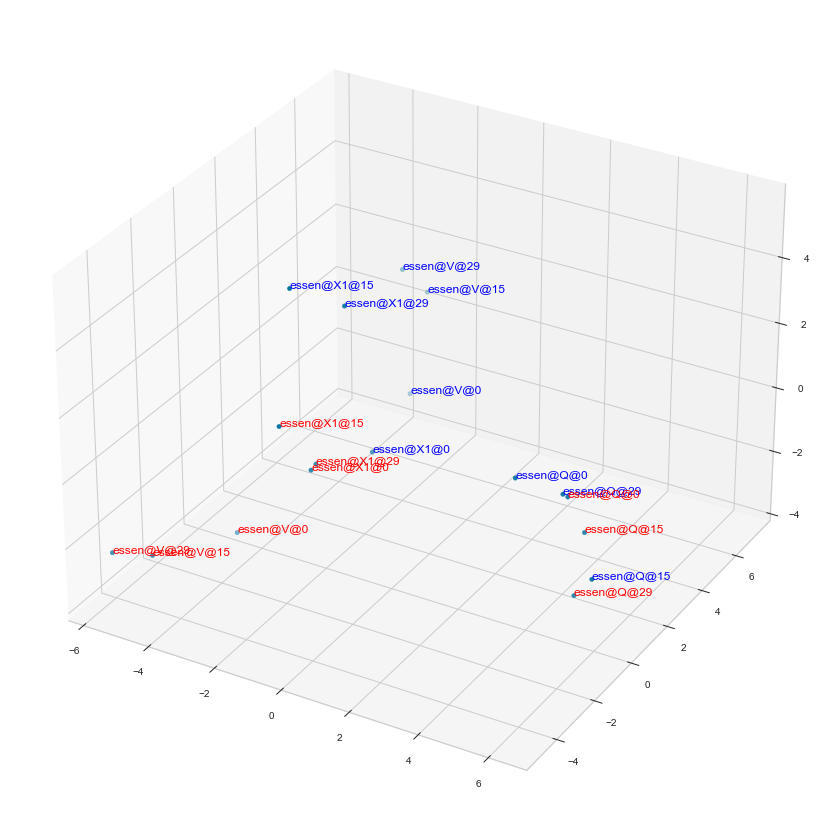

In [59]:
search_sentence = "wir konnen apfel essen"
steps_for_sample = get_by_word(search_sentence,["essen"],steps_decoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QVX")

search_sentence2 = "wir konnen brot essen"
steps_for_sample2 = get_by_word(search_sentence2,["essen"],steps_decoder_byword)
X_s2,Y_s2 = map_word_by_sentence(steps_for_sample2,includes="QVX")

Xs = X_s1 + X_s2
Ys = [ s for s in Y_s1] + [ s for s in Y_s2]
color_mapping = [ "#0000ff" for s in Y_s1] + [ "#ff0000" for s in Y_s2]

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

In [60]:
#pca = PCA(n_components=1)
#X_transformed = pca.fit_transform(np.array(Xs))
#df = pd.DataFrame()
#df["X"] = X_transformed.flatten()
#df["Y"] = Ys
#df


In [61]:
valid_sentences = []
for i in range(len(tabular_set)):
    valid_sentences.append(" ".join( tabular_set[i].src) )
    
valid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs,_ = test_sentence(tabular_set[i].src,draw_charts=False)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)
    valid_sentences_embeddings.append(trg4[0].numpy().flatten())

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'mochten', 'apfel', 'essen', '<eos>']
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']
src = ['i', 'want', 'to', 'drink', 'beer']
predicted trg = ['ich', 'mochten', 'bier', 'trinken', '<eos>']
src = ['i', 'want', 'to', 'read', 'book']
predicted trg = ['ich', 'mochten', 'buch', 'lesen', '<eos>']
src = ['i', 'want', 'to', 'read', 'newspaper']
predicted trg = ['ich', 'mochten', 'zeitung', 'lesen', '<eos>']
src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'apple']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'drink', 'water']
predicted trg = ['ich', 'konnen', 'wasser', 'trinken', '<eos>']
src = ['i', 'can', 'drink', 'beer']
predicted trg = ['ich', 'konnen', 'b

In [62]:
invalid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs,_ = test_sentence(tabular_set[i].src,draw_charts=False,attention_type=2)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)

    invalid_sentences_embeddings.append(trg4[0].numpy().flatten())

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'essen', 'brot', 'essen', '<eos>']
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'essen', 'apfel', 'essen', '<eos>']
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['ich', 'trinken', '<eos>']
src = ['i', 'want', 'to', 'drink', 'beer']
predicted trg = ['ich', 'trinken', '<eos>']
src = ['i', 'want', 'to', 'read', 'book']
predicted trg = ['ich', 'lesen', '<eos>']
src = ['i', 'want', 'to', 'read', 'newspaper']
predicted trg = ['ich', 'lesen', '<eos>']
src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'essen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'apple']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'drink', 'water']
predicted trg = ['ich', 'trinken', '<eos>']
src = ['i', 'can', 'drink', 'beer']
predicted trg = ['ich', 'trinken', '<eos>']
src = ['i', 'can', 'read', 'book']
predicted trg = ['ich', 'lesen', '<eos>']
src = ['i', 'can', '

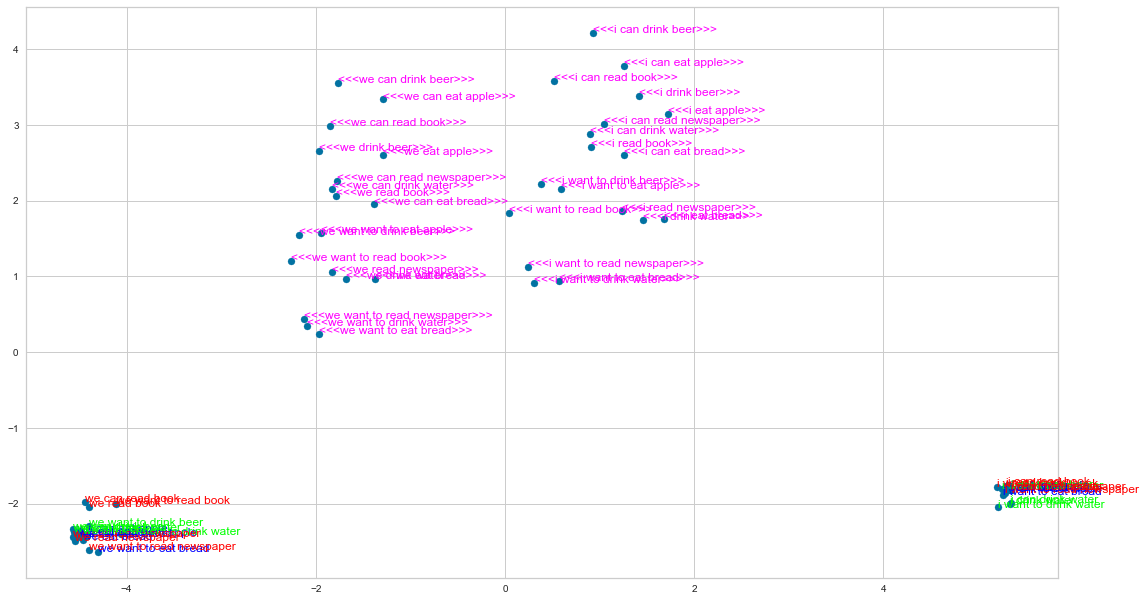

In [63]:
show_on_vis_multi(invalid_sentences_embeddings,valid_sentences,valid_sentences_embeddings,valid_sentences)


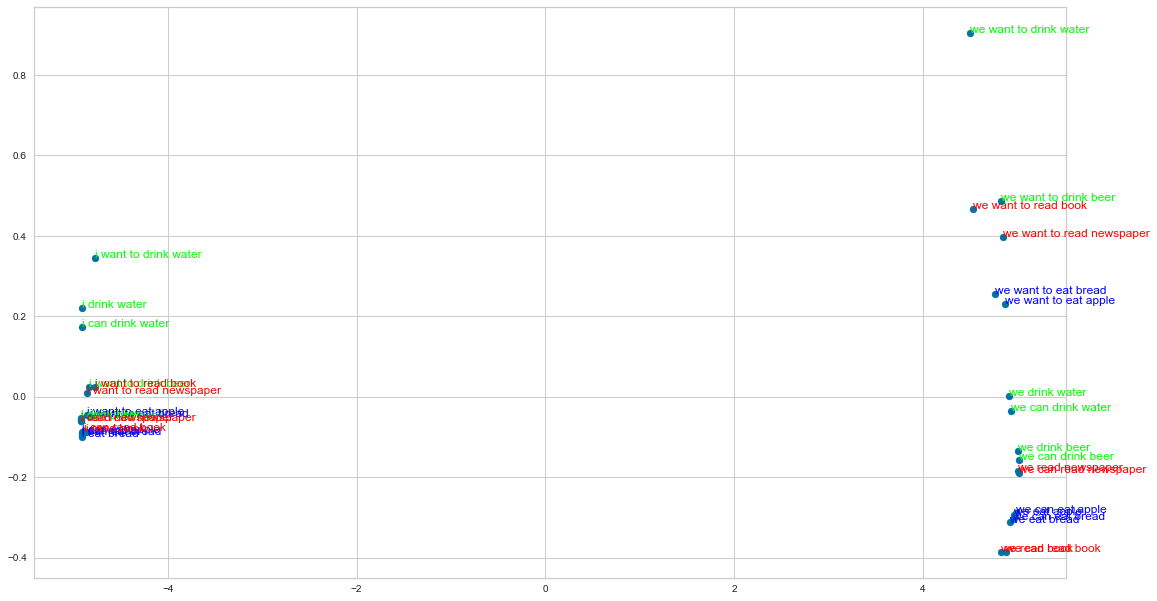

In [64]:
show_on_vis_multi([],[],valid_sentences_embeddings,valid_sentences)




src = ['i', 'can', 'read', 'book']
predicted trg = ['ich', 'konnen', 'buch', 'lesen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-1.118586,-1.849143,0.147934,-1.513777,8.044045,-0.268565,0.333908,-2.113700,-0.049566,-0.945592,-0.022613,-0.703588,-1.676022,-0.801387,-0.586949,-0.154729,-0.475162
2)konnen,-1.090207,-0.706185,-0.473529,-0.972306,-2.813708,-1.038559,-0.540601,7.648232,1.278379,1.006913,0.535250,0.239786,-0.524017,-0.155821,-2.288303,-1.382148,-2.513247
3)buch,-0.186433,-2.266264,-1.853301,1.294211,-1.165164,0.959306,-3.224926,-0.413463,1.571052,-2.684250,-1.613141,-0.205627,2.313285,-0.847443,6.328738,-0.033687,3.195642
4)lesen,-0.895372,-4.121304,-1.646725,2.350671,0.051805,-0.208816,-1.375120,-0.741785,6.991039,-3.340629,0.887732,-0.233245,0.765159,-0.302774,0.922765,1.013826,-1.367068
5)EOS,-1.039338,-2.843812,-1.706447,6.686838,-1.746948,-0.866557,-1.874737,2.358731,-0.202509,-4.457633,-0.754559,-1.171427,1.025445,-0.965976,3.119499,-0.701208,1.640350


figsize (5, 5)  n_cols  1   n_heads 1


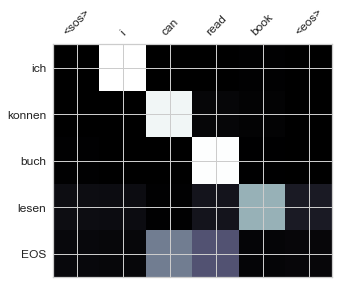

In [65]:
_ = test_sentence("i can read book",attention_type=1,draw_charts=True)

src = ['i', 'can', 'read', 'book']
predicted trg = ['ich', 'lesen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-1.935587,-2.229779,-0.619469,-0.531198,3.853479,2.505086,-2.640919,0.969466,1.393085,-3.396676,-0.334189,3.001619,-1.196283,-1.044338,0.520097,-2.424124,-2.399876
2)lesen,-1.316130,-2.679826,-2.718174,-1.462709,-1.944919,-2.309030,-0.229598,3.145455,4.362940,-0.231443,2.105780,1.619388,0.810347,-0.638343,-0.135823,-1.872643,-3.467195
3)EOS,-1.751754,-4.195683,-2.399050,5.461997,-0.771014,-2.240170,-1.437057,0.612554,0.886887,-5.193172,0.425624,0.473881,1.541634,-0.979994,2.475801,-0.074949,0.301481


figsize (5, 5)  n_cols  1   n_heads 1


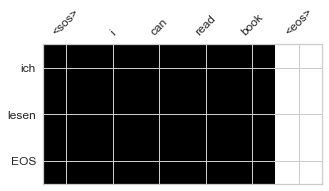

In [66]:
_ = test_sentence("i can read book",attention_type=4,draw_charts=True)

src = ['i', 'want', 'to', 'read', 'apple']
predicted trg = ['ich', 'mochten', 'buch', 'lesen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-1.115775,-1.830438,0.168298,-1.556371,8.052724,-0.221590,0.295258,-2.076819,-0.068363,-0.766441,-0.011770,-0.745542,-1.694855,-0.789930,-0.624406,-0.200776,-0.392716
2)mochten,0.182730,-0.133435,-2.778692,-2.628777,-1.483783,1.827608,-0.018432,1.433904,0.762023,8.166521,2.542296,-3.460709,0.233949,-1.117467,-1.658976,-1.273538,0.574205
3)buch,-0.943981,-1.517932,-1.825541,1.522217,-1.625926,-0.538095,-2.834262,-2.120682,0.050764,-4.604805,-1.263682,2.407286,2.423760,-0.372536,5.530604,0.701707,2.504563
4)lesen,-0.980331,-2.010634,-0.215699,-0.511169,0.268923,0.541682,-0.083868,-0.166121,4.776121,-1.629440,0.850129,1.109566,0.215272,-0.827323,0.018216,0.529413,-2.310734
5)EOS,-1.011327,-3.120491,-2.180856,6.603956,-1.178365,-1.185251,-1.589313,-1.636971,-0.824030,-3.750980,0.265386,-1.344286,1.133756,-0.906189,3.593381,-0.443052,2.657243


figsize (5, 5)  n_cols  1   n_heads 1


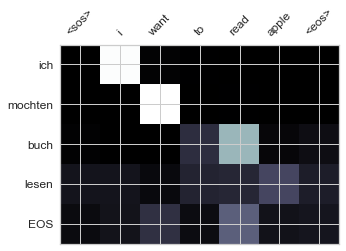

In [67]:
_ = test_sentence("i want to read apple",attention_type=1,draw_charts=True)

src = ['i', 'want', 'to', 'eat', 'book']
predicted trg = ['ich', 'mochten', 'bier', 'trinken', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-1.144500,-1.786136,0.203932,-1.611720,8.064525,-0.124446,0.342390,-2.037688,-0.085367,-0.842444,-0.076129,-0.668915,-1.773240,-0.774112,-0.664572,-0.167412,-0.486030
2)mochten,0.149857,-0.181152,-2.870432,-2.683064,-1.548714,1.696998,0.176139,1.468327,0.822381,8.057961,2.592296,-3.452633,0.281717,-1.129135,-1.671913,-1.239539,0.351301
3)bier,-1.206873,-1.420634,-2.017226,0.917748,-1.075556,-0.536610,-1.543909,-1.564775,0.166659,-3.997936,-1.290066,3.817344,4.007284,0.790105,3.873822,3.969800,0.472326
4)trinken,-2.218970,-1.381306,-2.114538,0.809498,-0.201666,-1.540732,1.326088,-3.376563,0.722942,-1.059237,5.256814,-0.132390,-0.796086,-1.410644,-0.922366,-0.329512,-2.309803
5)EOS,-1.084093,-3.973733,-2.280246,6.110700,-1.668736,-1.084766,-0.046083,-1.918009,1.075051,-5.695656,0.215519,2.067436,2.790345,-0.411215,2.939505,1.645700,-0.513233


figsize (5, 5)  n_cols  1   n_heads 1


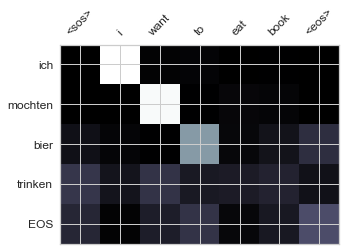

In [68]:
_ = test_sentence("i want to eat book",attention_type=1,draw_charts=True)
#i want to eat book too much saturated because of want to eat book,
#i can eat book is not this much saturated

src = ['i', 'can', 'eat', 'book']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-1.119264,-1.777691,0.237536,-1.535751,8.068046,-0.273929,0.400015,-2.090063,-0.107730,-0.975800,-0.071115,-0.640098,-1.776453,-0.772783,-0.672936,-0.132300,-0.488028
2)konnen,-1.150278,-0.715550,-0.496344,-0.995168,-2.783107,-1.099798,-0.188864,7.573418,1.120740,0.923012,0.478727,0.343790,-0.534576,-0.106276,-2.436371,-1.299410,-2.711493
3)apfel,-1.640437,-3.335166,-1.987549,2.222666,-0.977199,-1.990555,-1.053701,-0.426842,1.349077,-4.507259,-0.318288,4.399133,2.953555,1.579475,1.598200,2.480484,-1.146999
4)essen,-1.101418,-2.175278,-1.094216,1.968264,-0.117563,-1.128460,7.646113,-1.008330,-1.449718,-2.925181,-0.407405,-1.128872,0.085865,-0.411953,-0.727607,-0.445485,-3.354303
5)EOS,-0.393072,-3.744889,-2.368065,6.812248,-1.054824,-0.734173,-1.063158,-1.838040,1.087177,-4.685004,0.130617,3.241200,1.249852,2.108121,1.230586,0.205983,-1.057234


figsize (5, 5)  n_cols  1   n_heads 1


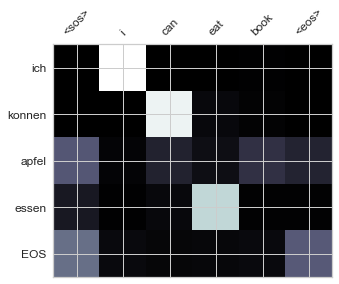

In [69]:
_ = test_sentence("i can eat book",attention_type=1,draw_charts=True)

src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-1.105053,-1.759303,0.246912,-1.525686,8.073839,-0.293713,0.436560,-2.103405,-0.145701,-0.930051,-0.080322,-0.656278,-1.787754,-0.736930,-0.703772,-0.136242,-0.454731
2)konnen,-1.109612,-0.643371,-0.452606,-1.002265,-2.776490,-1.082494,-0.126121,7.597728,1.008605,0.991211,0.415891,0.310531,-0.582151,-0.075814,-2.499604,-1.336182,-2.656368
3)brot,-1.270328,-1.863261,-2.346412,1.380979,-0.884615,-0.977642,1.230853,-0.124022,-0.026871,-1.942818,0.083549,2.144188,-0.847895,6.550308,-2.236249,-1.728094,0.767903
4)essen,-0.471504,-1.536761,-1.357249,2.471708,-0.479715,-1.195939,7.167397,-0.810455,-2.396710,-2.100556,0.314555,-1.041224,0.182073,0.216346,-1.341401,-0.533559,-3.921512
5)EOS,-0.123686,-2.573484,-2.458171,6.253654,-0.866947,-0.421201,0.007415,-0.572241,0.119733,-2.418878,0.174585,2.639058,-0.322409,5.391378,-2.255550,-2.501708,0.641088


figsize (5, 5)  n_cols  1   n_heads 1


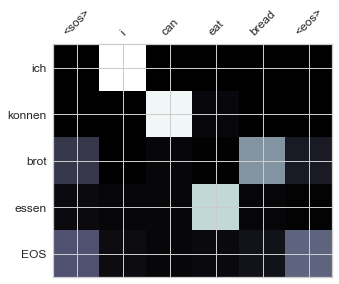

In [70]:
_ = test_sentence("i can eat bread",attention_type=1,draw_charts=True)


src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'essen', 'apfel', 'essen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-2.293564,-1.912756,-0.443662,-1.187955,4.649985,1.986584,0.441092,0.976502,-0.481240,-2.975734,-0.977185,2.615464,-2.669500,0.787618,-1.903225,-2.532951,-3.364338
2)essen,-1.128237,-1.933416,-2.113608,-2.086223,0.005706,-1.636584,3.358319,2.983780,1.271884,-0.337563,0.991096,0.986869,-2.210995,1.075652,-2.304046,-2.917490,-4.504419
3)apfel,-1.295766,-3.158865,-2.041400,3.072618,-0.999725,-1.709811,2.120815,0.920464,-0.443629,-3.034229,0.456773,3.133399,-0.243371,2.954291,-1.007584,-0.990200,-3.433047
4)essen,-2.059795,-3.661178,-0.318575,2.338808,0.645194,-1.598648,5.182137,0.485463,0.513781,-3.607545,-0.254387,0.777502,-1.148593,0.819955,-2.072416,-1.614251,-2.940996
5)EOS,-1.080410,-3.042137,-1.995471,4.484415,-1.016642,-1.639747,2.064928,0.587196,-0.589765,-3.552999,0.276010,3.239052,0.175641,3.367900,-0.952972,-1.185108,-2.880959


figsize (5, 5)  n_cols  1   n_heads 1


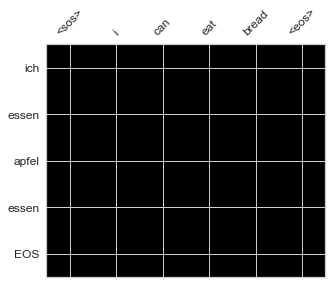

In [71]:
_ = test_sentence("i can eat bread",attention_type=2,draw_charts=True)


src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'essen', 'brot', 'essen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)ich,-2.181481,-1.878312,-0.912724,-1.987182,5.496173,3.439250,-0.053734,-0.783187,-0.333130,-1.083771,-0.423197,1.482910,-2.350811,0.311174,-1.481735,-2.185181,-2.877600
2)essen,-1.097441,-1.639557,-3.381513,-2.675425,-1.583520,-1.774754,3.421484,1.449548,1.740139,3.176090,2.824704,-0.563197,-0.338006,0.707945,-2.461822,-1.780154,-3.727482
3)brot,-0.990319,-3.757444,-3.096619,2.539800,-0.646468,-0.879912,1.742388,-0.838775,-0.115359,-0.413487,1.631493,1.834484,0.321734,2.702849,-0.544560,-0.445870,-2.905131
4)essen,-0.424749,-1.801819,-0.213462,1.607566,0.159597,-0.228833,4.301430,-0.893216,-0.978771,-1.322951,1.613391,0.230566,-0.195821,0.481720,-2.218517,-0.634126,-5.098227
5)EOS,-1.033234,-3.960915,-3.098224,4.406256,-0.797931,-1.187873,1.955958,-0.999767,-0.466738,-1.118460,1.354237,1.851348,0.739632,3.113814,-0.396045,-0.592084,-2.232565


figsize (5, 5)  n_cols  1   n_heads 1


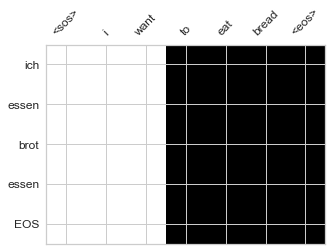

In [72]:
_ = test_sentence("i want to eat bread",attention_type=3,draw_charts=True)


In [73]:
#show self attentions on encoder layer
for index in [1,5,15,25,30]:
    
    test_logger,all_outputs,_ = test_sentence(tabular_set[index].src,draw_charts=False,attention_type=1)
    encoded_attention = test_logger.get_summary(["EncoderLayer@sattention"],show_data=False)        
    
    output_words = ["sos"]+tabular_set[index].src  +["eos"]
    for head_index in range(encoded_attention[0].shape[1]):
        all_outputs0 = encoded_attention[0][:,head_index,:,:]
        draw_df(all_outputs0.squeeze().numpy(),output_words,output_words)

src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'mochten', 'apfel', 'essen', '<eos>']


,sos,i,want,to,eat,apple,eos
sos,0.009098,0.060590,0.666159,0.114431,0.022562,0.027665,0.099495
i,0.681229,0.088335,0.024309,0.082985,0.116567,0.001445,0.005131
want,0.007755,0.023490,0.013216,0.945696,0.004321,0.000173,0.005350
to,0.011620,0.010743,0.005992,0.005936,0.070555,0.890230,0.004924
eat,0.425366,0.012499,0.052331,0.146104,0.089422,0.227458,0.046820
apple,0.004143,0.000060,0.005884,0.004627,0.001500,0.977718,0.006068
eos,0.004894,0.001061,0.006803,0.017370,0.001347,0.965580,0.002945


src = ['i', 'want', 'to', 'read', 'newspaper']
predicted trg = ['ich', 'mochten', 'zeitung', 'lesen', '<eos>']


,sos,i,want,to,read,newspaper,eos
sos,0.000229,0.001523,0.016750,0.002877,0.002303,0.973816,0.002502
i,0.767715,0.099549,0.027395,0.093520,0.002519,0.003519,0.005782
want,0.007697,0.023316,0.013117,0.938677,0.006804,0.005079,0.005310
to,0.012564,0.011616,0.006478,0.006419,0.005415,0.952184,0.005324
read,0.000394,0.000373,0.042086,0.001544,0.000187,0.954827,0.000588
newspaper,0.023818,0.321042,0.014737,0.202094,0.019696,0.385469,0.033144
eos,0.013276,0.002877,0.018454,0.047115,0.000703,0.909586,0.007989


src = ['we', 'want', 'to', 'drink', 'beer']
predicted trg = ['wir', 'mochten', 'bier', 'trinken', '<eos>']


,sos,we,want,to,drink,beer,eos
sos,0.001613,0.003035,0.118093,0.020286,0.833848,0.005487,0.017638
we,0.003595,0.962381,0.008689,0.003899,0.011783,0.000603,0.009051
want,0.007821,0.002204,0.013329,0.953784,0.009166,0.008301,0.005396
to,0.208914,0.111492,0.107724,0.106731,0.039045,0.337565,0.088529
drink,0.059982,0.004828,0.038457,0.118319,0.004272,0.748397,0.025745
beer,0.004489,0.005848,0.341814,0.326335,0.147200,0.153177,0.021137
eos,0.045781,0.005857,0.063639,0.162475,0.054535,0.640163,0.027550


src = ['i', 'eat', 'apple']
predicted trg = ['ich', 'essen', 'apfel', '<eos>']


,sos,i,eat,apple,eos
sos,0.043408,0.289093,0.089184,0.134665,0.443651
i,0.759748,0.098516,0.134827,0.001606,0.005302
eat,0.468565,0.012552,0.144497,0.339842,0.034543
apple,0.002799,0.000046,0.001137,0.991033,0.004985
eos,0.005190,0.001910,0.002221,0.985580,0.005100


src = ['we', 'eat', 'bread']
predicted trg = ['wir', 'essen', '<eos>']


,sos,we,eat,bread,eos
sos,0.001364,0.002568,0.002803,0.979320,0.013944
we,0.003535,0.946473,0.022775,0.017803,0.009414
eat,0.577368,0.093592,0.178050,0.108427,0.042563
bread,0.002109,0.006160,0.000415,0.985160,0.006157
eos,0.002308,0.000484,0.000988,0.993953,0.002268


In [74]:
last_sentence_original_batch = None

In [75]:
steps_encoder_bysentence = []
LANG = SRC          #TOCHANGE
last_sentence_encoding_batch = None

for i in range(len(data_pipeline)):
    #print( data_pipeline[i][0] )
    current_label = data_pipeline[i][0]
    if "encoder@QKV" == current_label: # TODO  decoder_encoder_attention@QKV
         #cnt += 1
         #print("i",i)
         sentence_batch = last_sentence_original_batch
         batch_len = sentence_batch.shape[0]   
         #assert batch_len == len(data_pipeline[i][1] )         
         for sent_index in range(batch_len):  
            sentence = sentence_batch[sent_index]
            data_part = data_pipeline[i][1]
            original_embedding = last_sentence_original_batch[sent_index]
            translation = " ".join( encoding_to_sentence(original_embedding,LANG) )
            dstep = DebugStepWord(sentence,translation)
            dstep.original_embedding = original_embedding 
            dstep.q = data_pipeline[i][1][0][sent_index].squeeze().detach()
            dstep.k = data_pipeline[i][1][1][sent_index].squeeze().detach()
            dstep.v = data_pipeline[i][1][2][sent_index].squeeze().detach()
            dstep.energy = data_pipeline[i][1][4][sent_index].squeeze().detach()
            dstep.attention = data_pipeline[i][1][5][sent_index].squeeze().detach()
            dstep.mask = data_pipeline[i][1][6][sent_index].squeeze().detach()
            dstep.x1 = data_pipeline[i][1][7][sent_index].squeeze().detach()
            steps_encoder_bysentence.append(dstep)
    if "Encoder->attention" == current_label: #TODO  Decoder->attention
         #print("i",i)
         last_sentence_original_batch = data_pipeline[i][1]
    
             

In [76]:
assert list(steps_encoder_bysentence[0].q.shape) == [7,64]
assert N_EPOCHS * len(steps_encoder_bysentence) * 36
print( " epochs: ",N_EPOCHS , " log length : ", len(steps_encoder_bysentence) )
assert steps_encoder_bysentence[0].v.shape[0] == 7
assert steps_encoder_bysentence[0].v.shape[1] == HID_DIM 

 epochs:  30  log length :  1080


In [77]:
steps_encoder_byword = []
for step in steps_encoder_bysentence:
    word_count = step.q.shape[0]
    for i in range(word_count):        
        word_step = DebugStepWord(step.sentence,step.translation)    
        #print("step.q",step.q.shape)
        word_step.q = step.q[i]
        word_step.k = step.k[i]
        word_step.v = step.v[i]
        word_step.energy = step.energy[i]
        word_step.attention = step.attention[i]
        word_step.mask = step.mask[i]
        word_step.x1 = step.x1[i]
        word_step.sentence = step.sentence
        word_step.translation = step.translation
        word_step.word_vector = step.sentence[i]
        word_step.word_embeddding = step.original_embedding[i]
        #print("step.sentence.squeeze()[i]",word_step.word_embeddding )
        word_step.word_translation = encoding_to_word(word_step.word_embeddding,LANG)
        steps_encoder_byword.append( word_step )



In [78]:
steps_encoder_byword[0]

In [79]:
assert steps_encoder_byword[0].q.shape[0] == 64 
steps_encoder_byword[0].word_vector


tensor(2)

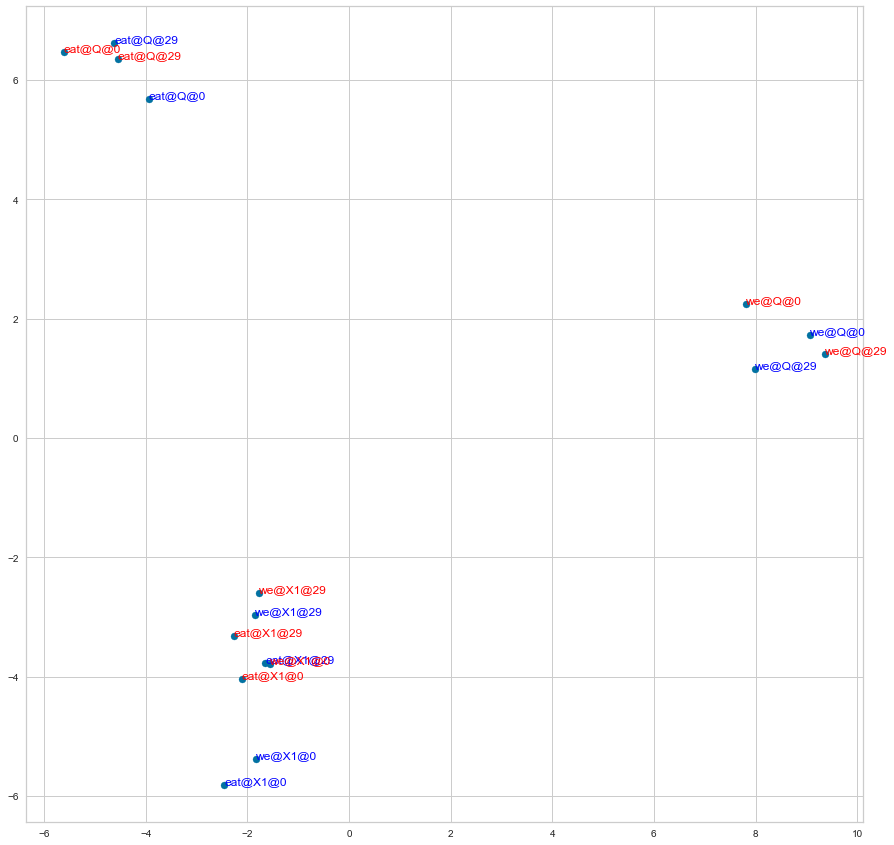

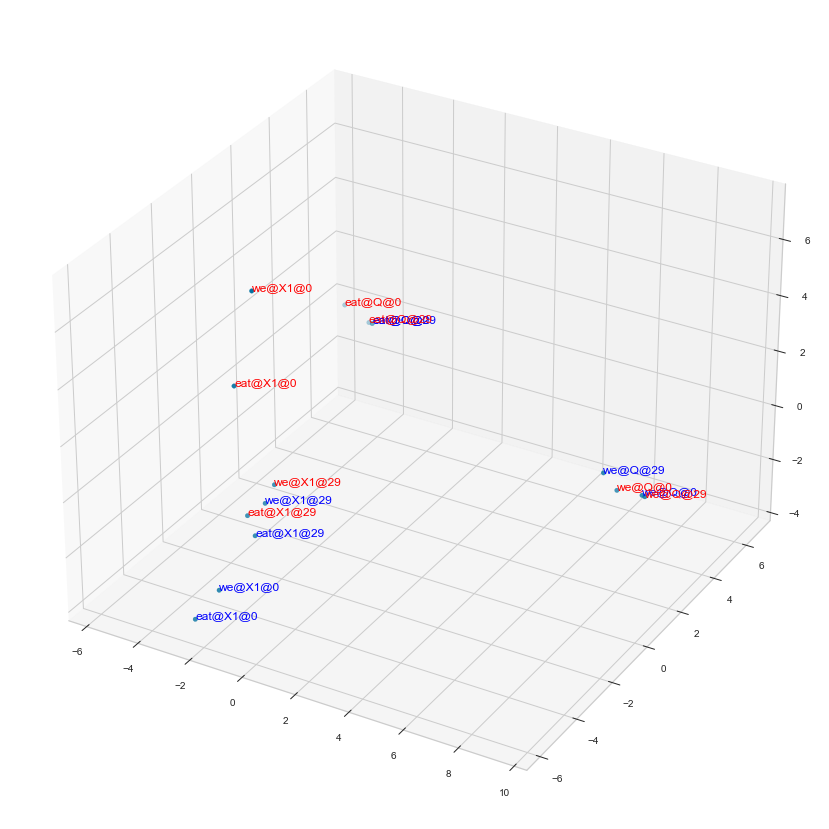

In [80]:
#altough "eat" and "we" are same their encodings differ in space, this sample
#has lets distinctive power than others
search_sentence = "we can eat apple"
steps_for_sample = get_by_word(search_sentence,["eat","we"],steps_encoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QX",ranks=[0,29])

search_sentence2 = "we can eat bread"
steps_for_sample2 = get_by_word(search_sentence2,["eat","we"],steps_encoder_byword)
X_s2,Y_s2 = map_word_by_sentence(steps_for_sample2,includes="QX",ranks=[0,29])

Xs = X_s1 + X_s2
Ys = [ s for s in Y_s1] + [ s for s in Y_s2]
color_mapping = [ "#0000ff" for s in Y_s1] + [ "#ff0000" for s in Y_s2]

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

In [81]:
def collect_sentence_data(sentences,vector_name,indexes,keywords,use_last_vector=False,dump_result=False):
    print("vector_name",vector_name)
    Xs = []
    Ys = []
    for sentence_index,sentence in enumerate(sentences):
        test_logger,_,translation = test_sentence(sentence,attention_type=1,draw_charts=False,dump_result=dump_result)
        x4 = test_logger.get_summary([vector_name],show_data=False,summary_count=10)
        if use_last_vector:
            x4 = x4[len(x4)-1]
        
        for i,index in enumerate(indexes):
            #if use_last_vector it is decoder so we must use result from translation
            if use_last_vector:
                key = translation[index]
            else:    
                key = keywords[i]
            val = x4[0].squeeze()[index].numpy()
            Xs.append(val)
            Ys.append(key+"@"+str(sentence_index))
    return Xs,Ys

def dump_on_2d(Xs,Ys):
    colors =["#ff0000","#aa0000","#00ffdd","#0000ff","#ffaaaa"] 
    color_mapping = [ colors[int(y.split("@")[1])] for y in Ys]
    #print(color_mapping)
                             
    pca = PCA(n_components=3)
    X_transformed = pca.fit_transform(np.array(Xs))
    map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10])
    

src = ['i', 'can', 'read', 'apple']
predicted trg = ['ich', 'konnen', 'buch', 'lesen', '<eos>']
translation ['ich', 'konnen', 'buch', 'lesen', 'EOS']
vector_name encoder@Q
src = ['i', 'can', 'eat', 'apple']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'book']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'newspaper']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'apple', 'book']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']


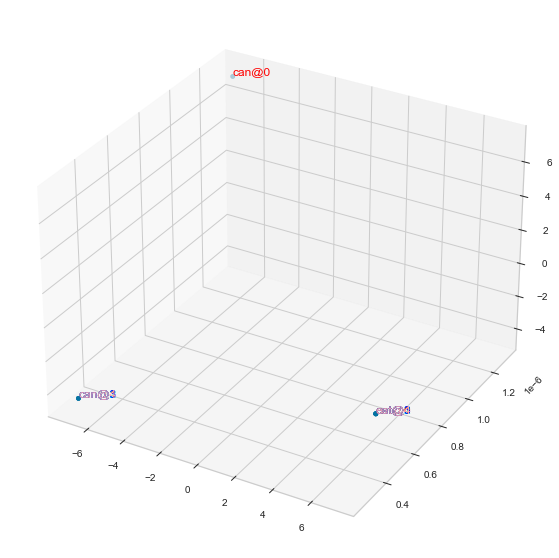

vector_name encoder@K


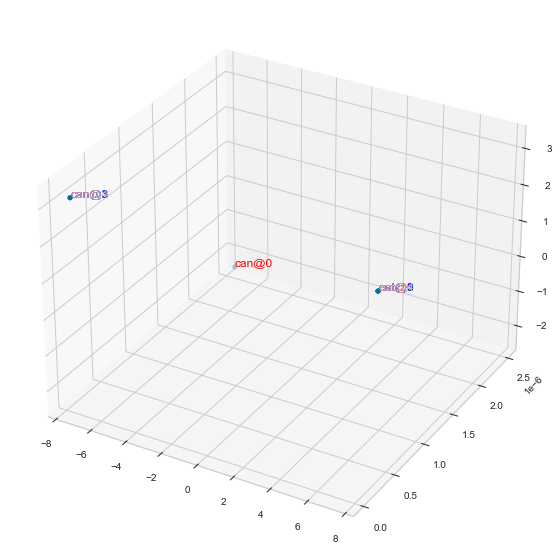

vector_name encoder@V


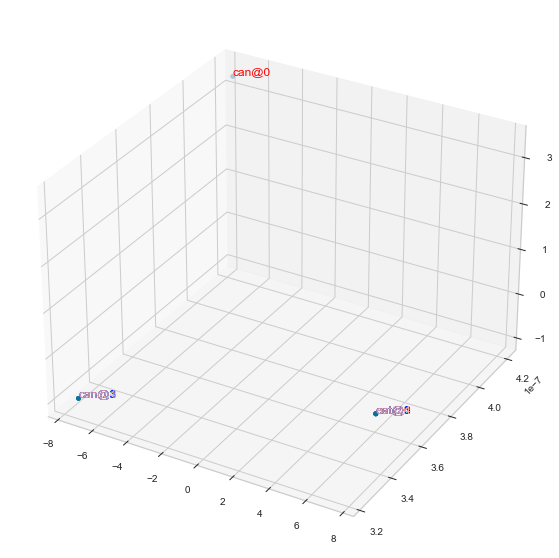

vector_name encoder@x1


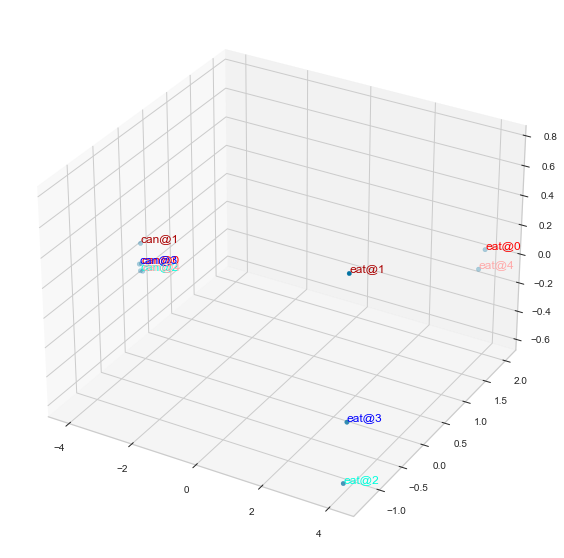

vector_name encoder@x4


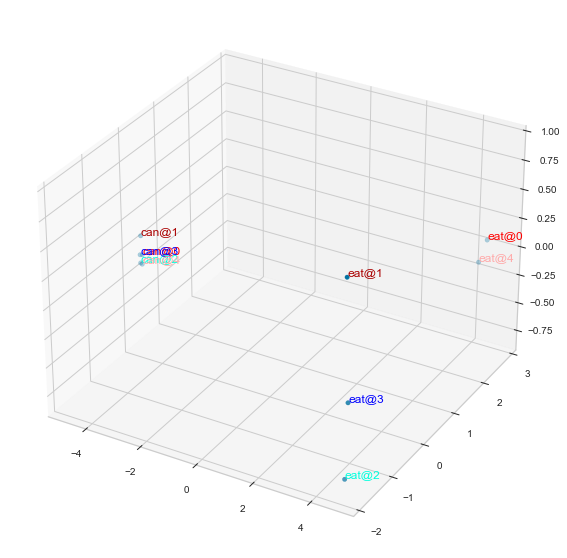

vector_name Encoder@src_final


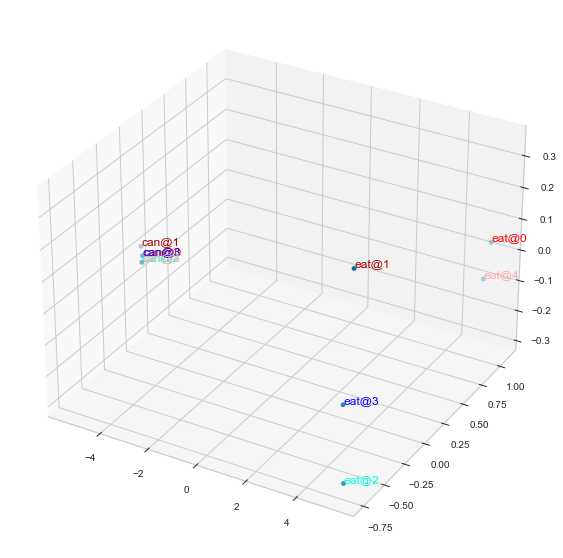

In [82]:
     



#def get_summary(self,labels,show_data=False,show_info=False,summary_count=1):
"""
test_logger,_ = test_sentence("i read book",attention_type=1,draw_charts=False)
#a[0].get_default_summary()
x1 = test_logger.get_summary(["encoder@x1"],show_data=False,summary_count=10)
x4 = test_logger.get_summary(["encoder@x4"],show_data=False,summary_count=10)
print(x1[0].shape)
print(x4[0].shape)

test_logger,_ = test_sentence("i can read apple",attention_type=1,draw_charts=False)
#a[0].get_default_summary()
#test_logger.get_default_summary()
x1 = test_logger.get_summary(["encoder@x1"],show_data=False,summary_count=10)
x4 = test_logger.get_summary(["encoder@x4"],show_data=False,summary_count=10)
print(x1[0].shape)
print(x4[0].shape)
"""

test_logger,_,translation = test_sentence("i can read apple",attention_type=1,draw_charts=False)
print("translation",translation)

indexes = [2,3]
words = ["can","read"]
#x4[0].squeeze().shape
test_sentences = ["i can eat apple","i can eat bread","i can eat book","i can eat newspaper","i can eat apple book"]

indexes = [2,3]
keywords = ["can","eat"]

Xs,Ys = collect_sentence_data(test_sentences,"encoder@Q",indexes,keywords,dump_result=True)
dump_on_2d( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@K",indexes,keywords)
dump_on_2d( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@V",indexes,keywords)
dump_on_2d( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@x1",indexes,keywords)
dump_on_2d( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@x4",indexes,keywords)
dump_on_2d( Xs,Ys )

Xs,Ys = collect_sentence_data(test_sentences,"Encoder@src_final",indexes,keywords)
dump_on_2d( Xs,Ys )
#Xs,Ys = collect_sentence_data(test_sentences,"EncoderLayer@_src2",[2,3],["can","read"])
#dump_on_2d( Xs,Ys )
#Xs,Ys = collect_sentence_data(test_sentences,"EncoderLayer@src3",[2,3],["can","read"])
#dump_on_2d( Xs,Ys )



#Xs,Ys = collect_sentence_data(["i can read book","i can read newspaper","i can read apple","i can read water"],[3],["read"])


#'can@0'
#colors =["#ff0000","#aa0000","#00ffdd","#0000ff"] 
#color_mapping = [ colors[int(y.split("@")[1])] for y in Ys]
#print(color_mapping)
                             
#pca = PCA(n_components=2)
#X_transformed = pca.fit_transform(np.array(Xs))
#map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10]) 


vector_name decoder_encoder_attention@Q
src = ['i', 'can', 'eat', 'apple']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'book']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'newspaper']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']
src = ['i', 'can', 'eat', 'apple', 'book']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']


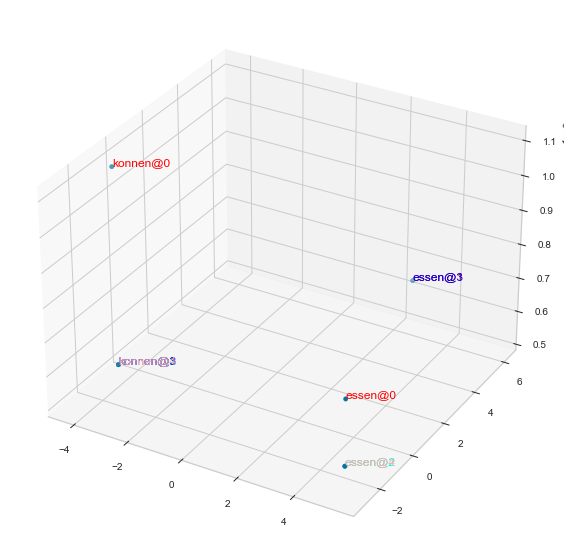

vector_name decoder_encoder_attention@K


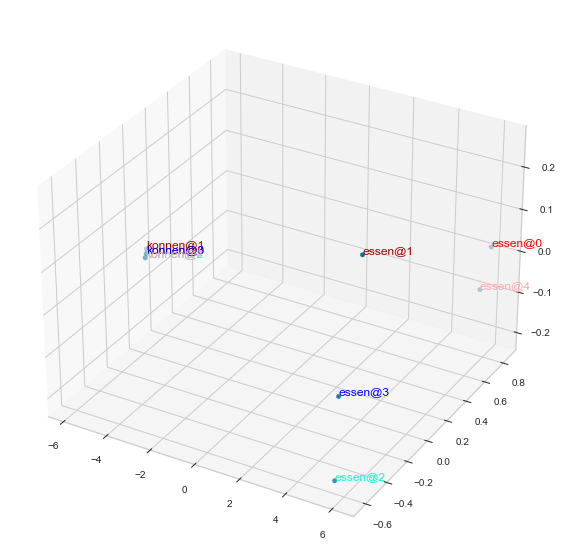

vector_name decoder_encoder_attention@V


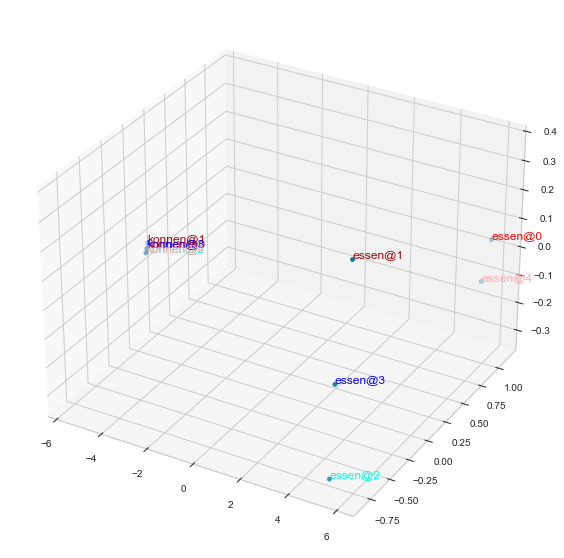

vector_name decoder_encoder_attention@x4


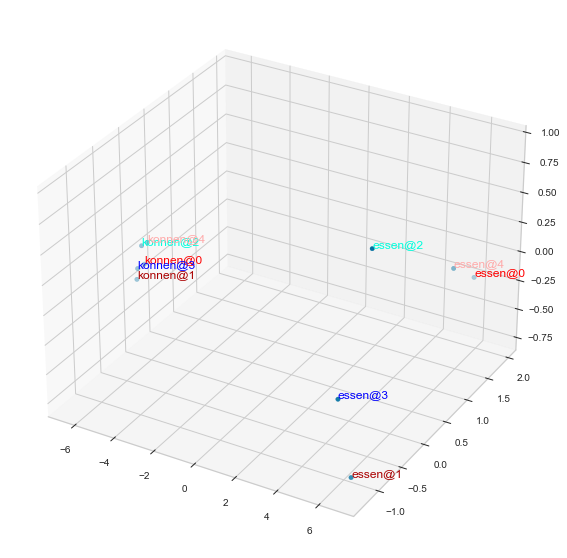

vector_name Decoder@output


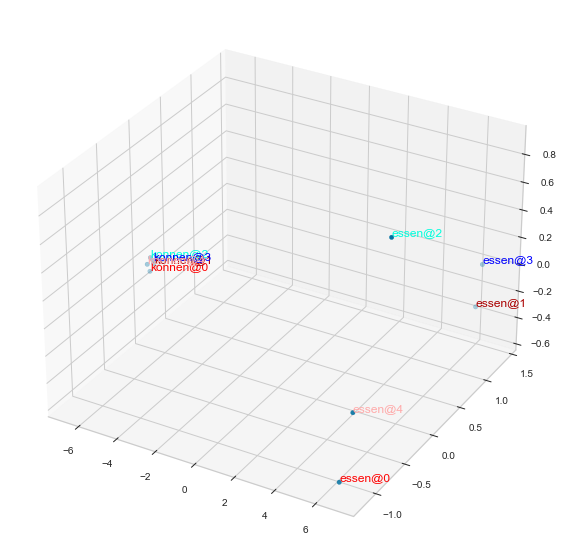

In [83]:



test_sentences = ["i can eat apple","i can eat bread","i can eat book","i can eat newspaper","i can eat apple book"]

indexes = [1,3]
keywords = None

Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@Q",indexes,keywords,use_last_vector=True,dump_result=True)
dump_on_2d( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@K",indexes,keywords,use_last_vector=True)
dump_on_2d( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@V",indexes,keywords,use_last_vector=True)
dump_on_2d( Xs,Ys )

Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@x4",indexes,keywords,use_last_vector=True)
dump_on_2d( Xs,Ys )

Xs,Ys = collect_sentence_data(test_sentences,"Decoder@output",indexes,keywords,use_last_vector=True)
dump_on_2d( Xs,Ys )



In [84]:
#how does encoding of EAT chanes according to time
#lets do over over simplifaction and map is to 1d
search_sentence = "we can eat apple"
steps_for_sample = get_by_word(search_sentence,["eat","apple"],steps_encoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QVKX",ranks=[0,15,29])

X1d,Y1d = filter_by_key(X_s1,Y_s1,["eat"])
pca = PCA(n_components=1)
X_transformed = pca.fit_transform(np.array(X1d))
X_transformed = [x[0] for x in X_transformed]

df = pd.DataFrame()


mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@0","eat@K@0","eat@V@0","eat@X1@0"])
mapped_vals["qvk"] = mapped_vals["eat@Q@0"] * mapped_vals["eat@K@0"] * mapped_vals["eat@V@0"] 
df["apple_0"] = mapped_vals.keys()
df["apple_0 values"] = mapped_vals.values()

mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@29","eat@K@29","eat@V@29","eat@X1@29"])

mapped_vals["qvk"] = mapped_vals["eat@Q@29"] * mapped_vals["eat@K@29"] * mapped_vals["eat@V@29"] 


df["apple_29"] = mapped_vals.keys()
df["apple_29 values"] = mapped_vals.values()

#----------------------------
search_sentence = "we can eat bread"
steps_for_sample = get_by_word(search_sentence,["eat","bread"],steps_encoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QVKX",ranks=[0,15,29])

X1d,Y1d = filter_by_key(X_s1,Y_s1,["eat"])
pca = PCA(n_components=1)
X_transformed = pca.fit_transform(np.array(X1d))
X_transformed = [x[0] for x in X_transformed]

mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@0","eat@K@0","eat@V@0","eat@X1@0"])
mapped_vals["qvk"] = mapped_vals["eat@Q@0"] * mapped_vals["eat@K@0"] * mapped_vals["eat@V@0"] 
df["bread_0"] = mapped_vals.keys()
df["bread_0 values"] = mapped_vals.values()

mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@29","eat@K@29","eat@V@29","eat@X1@29"])
mapped_vals["qvk"] = mapped_vals["eat@Q@29"] * mapped_vals["eat@K@29"] * mapped_vals["eat@V@29"] 

df["bread_29"] = mapped_vals.keys()
df["bread_29 values"] = mapped_vals.values()
df.head(5)

,apple_0,apple_0 values,apple_29,apple_29 values,bread_0,bread_0 values,bread_29,bread_29 values
0,eat@Q@0,2.648165,eat@Q@29,3.364108,eat@Q@0,0.256456,eat@Q@29,1.036421
1,eat@K@0,7.927295,eat@K@29,8.159241,eat@K@0,8.355412,eat@K@29,8.402350
2,eat@V@0,-8.075520,eat@V@29,-6.369615,eat@V@0,-8.335660,eat@V@29,-6.739810
3,eat@X1@0,-4.439899,eat@X1@29,-0.745456,eat@X1@0,-0.784702,eat@X1@29,-1.552399
4,qvk,-169.527679,qvk,-174.836807,qvk,-17.861595,qvk,-58.692776


In [85]:
#X1d,Y1d = filter_by_key(Xs,Ys,["eat"])
#pca = PCA(n_components=1)
#X_transformed = pca.fit_transform(np.array(X1d))
#pd.DataFrame( data={"x":X_transformed.flatten(), "y":Y1d }).sort_values(by=["y"])

In [86]:
dddddddddddddddddddddddddd

NameError: name 'dddddddddddddddddddddddddd' is not defined

In [ ]:
add_new_logger("test_loss")

In [ ]:
test_loss = evaluate(model, test_iterator, criterion,attention_type=1)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [ ]:
#current_logger.get_default_summary(show_data=False)

In [ ]:
#test_logger.get_default_summary(show_data=True)
for index in range(20,30):
    
    test_logger,all_outputs,_ = test_sentence(tabular_set[index].src,draw_charts=False,attention_type=1)
    encoded_attention = test_logger.get_summary(["EncoderLayer@sattention"],show_data=False)
    
    src_masks = test_logger.get_summary(["EncoderLayer@src_mask"],show_data=False,summary_count=10)
    #print("EncoderLayersrc_masks",src_masks)
    
    decodersrc_masks = test_logger.get_summary(["DecoderLayer@src_mask"],show_data=False,summary_count=10)
    #print("decodersrc_masks",decodersrc_masks)
    
    
    decoder_attention = test_logger.get_summary(["Decoder@attention"],show_data=False,summary_count=10)
    #print("decoder_attention",decoder_attention[0].shape)
    #print("decoder_attention",decoder_attention[0])
    
    decodertrg_masks = test_logger.get_summary(["DecoderLayer@trg_mask"],show_data=False,summary_count=10)
    #for index2,dm in enumerate(decodertrg_masks):
    #    print("decodertrg_masks",index2)
    #    print(dm)
    
    output_words = ["sos"]+tabular_set[index].src  +["eos"]
    for head_index in range(encoded_attention[0].shape[1]):
        all_outputs0 = encoded_attention[0][:,head_index,:,:]
        draw_df(all_outputs0.squeeze().numpy(),output_words,output_words)
    
    ### OPEN THIS COMMENT FOR MULTI HEAD all_outputs1 = encoded_attention[0][:,1,:,:]
    ###draw_df(all_outputs1.squeeze().numpy(),output_words,output_words)
#df2 = pd.DataFrame(all_outputs.squeeze().numpy(),columns=output_words,index=output_words)
#cm = sns.light_palette("blue", as_cmap=True)

#styled_df = df2.style.background_gradient(cmap=cm)
#styled_df
#i want to read newspaper  diagonal
#i can eat bread  diagonal
#we can eat bread diagonal
#we can read book , very diagonal
#we can read newspaper , very diagonal
#i eat bread , very diagonal
#when want to comes into ,patterns change

In [ ]:
#loggers.keys()

In [ ]:
loggers["training"].get_default_summary()


In [ ]:
loggers["test_loss"].get_default_summary()


In [ ]:
loggers["sample1"].get_default_summary()


In [ ]:
current_logger.get_default_summary(show_data=False)

In [ ]:
#currentLogger.get_default_summary(show_data=False)

In [ ]:

#currentLogger.get_summary(labels=["Q"],show_data=True)

In [ ]:
#loggers.keys()

In [ ]:
loggers["sample1"].get_default_summary(show_data=False)

In [ ]:
attention_orig = loggers["sample1"].get_summary(labels=["decoder_encoder_attention@attention"],show_data=True)
trg4 = loggers["sample1"].get_summary(labels=["DecoderLayer@trg4"],show_data=True)

In [ ]:
add_new_logger("sample3")
example_idx = 18

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

currentLogger = StepLogger(100)  
translation, attention, all_outputs = translate_sentence(src, SRC, TRG, model, device,attention_type=3)

print(f'predicted trg = {translation}')
 
display_attention(src, translation, attention,n_heads=get_head_count(),n_rows = get_row_count(), n_cols = get_col_count())

In [ ]:

for i in range( len(tabular_set)):
    print(" ".join(tabular_set[i].src))
    

In [ ]:
tabular_set[i].src


In [ ]:
tt = torch.tensor(np.full((1, 2, 1, 6), 1/6) )

att1 = torch.tensor(np.full((tt.shape[0], tt.shape[1], tt.shape[2], 3), 1/3) )
att2 = torch.tensor(np.full((tt.shape[0], tt.shape[1], tt.shape[2], tt.shape[3] - 3), 1/7) )
att3 = torch.cat( (att1,att2),3 )
att4 = torch.softmax(att3, dim = -1)
att4